In [1]:
import numpy as np   # import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.signal import argrelextrema



In [2]:
#Create uniform y-axis limit
def create_ylimit(df):
    #find the standard deviation and mean of each column from the dataset without zeros
    df_limit=df.replace(0, np.nan)
    std=df_limit.std()
    mean=df_limit.mean()
    #Find mean and standard deviation of all of the data
    df_mean=np.mean(mean)
    df_std =np.mean(std)
    #y limit = mean of the dataframe plus 3 standard deviations
    y_limit = df_mean +3*df_std
    return y_limit

def plot_night_test(df):
    #Make a copy of the dataframe and create two columns for the difference between the light values and for the date and time
    dfc = df.copy()
    dfc['diff'] = dfc.Light.diff()
    dfc[["day", "time"]] = dfc["Date-Time"].str.split(" ", expand = True)
    #Separate by the difference to determine when the light is coming on or going off
    df_off = dfc.loc[dfc['diff'] == 1]
    df_on = dfc.loc[dfc['diff'] == -1]
    #display(dfc)
    #Assign variable from the lists
    start1 = dfc.time.values[0]
    end1 = df_off.time.values[0]
    start2 = df_on.time.values[0]
    end2 = dfc.time.values[-1]

    return start1, start2, end1, end2

#Plot activity in subplots
#Imput:Dataframe, List of spiders in df, Specific Spider from list, 
#Label for subplots, variable from "create_ylimit" funnction 
#All variables will be named in final raster plot function
def plot_raster( df, column, spider, ax, y, num_days, min_day): 
    
    for i in range(0,num_days):
        #Separate dataframe into sections of 1440 minutes(minutes in a day) and plot the 
        #activity for each day
        ax[i].plot(df['time'][min_day*i:min_day*(i+1)], df[column[spider]][min_day*i:min_day*(i+1)], color='blue')
        #Label each day
        ax[i].set_ylabel('d'+str(i+1))
        ax[i].set_xticks([])
        # the y limit is the mean plus 3 standard deviations
        ax[i].set_ylim(0,y)
        #setting instructions for shading the graph when the lights are off
        df1=df[min_day*(i):min_day*(i+1)]
        df1=df1.reset_index()
        #Make DD plots all grey
        if np.mean(df1.Light)==0:
            ax[i].set_facecolor("silver")
        elif np.mean(df1.Light)>.55:
            print('Constant Light')
        #Run function to determine when lights are off during LD cycle
        else:
            start1, start2, end1, end2 = plot_night_test(df1)
            #print(start1, end1,start2, end2)
            ax[i].axvspan(start1, end1, alpha=0.5, color='grey')
            ax[i].axvspan(start2, end2,alpha=0.5, color='grey')
            
#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster(df):
    column=df.columns[1:]
    #create a copy and separate the date and time for reference
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date-Time"].str.split(" ", expand = True)
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        total_time = len(dftest.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        x=int(1440/4)
        ax[num_days-1].set_xticks([0,x,2*x,3*x,4*x],['0:00','6:00','12:00','18:00','24:00'])
        plt.xlabel('Subjective Time')
        #save figure
        #fig.savefig(column[spider] +'raster_DD_TEMP')
        plt.show()
        print('Next spider')
      
    
    
    
    
######################



#Combine all funtions to make raster plots for all spiders given a data frame and list of spiders
def spider_raster_per(df, per):
    column=df.columns[1:]
    perT = per.T
    #create a copy and separate the date and time for reference
    df_time = df.copy()
    df_time=df_time.reset_index()
    df_time[["day", "time"]] = df_time["Date-Time"].str.split(" ", expand = True)
    #for loop for creating figures for the number of spiders in the dataframe
    for spider in  range(len(column)):
        #Determine length of usable data for each spider
        dftest=df[column[spider]].dropna()
        print(column[spider])
        min_day = int((perT[column[spider]].values) * 60)
        #sub_mins_day = per.iloc[0]['A']
        #print(min_day)
        total_time = len(df.index)
        num_days = total_time//min_day
        #Plot subplots
        fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)
        fig.suptitle('The Free Running Period of: ' + column[spider], fontsize=16)        
        #setting the y axis limit
        y = create_ylimit(df) 
        #plotting the raster plots
        plot_raster(df_time, column, spider, ax, y, num_days, min_day)
        #plot x axis
        x=int(1440/4)
        ax[num_days-1].set_xticks([0,x,2*x,3*x,4*x],['0:00','6:00','12:00','18:00','24:00'])
        plt.xlabel('Subjective Time')
        #save figure
        #fig.savefig(column[spider] +'raster_DD_Period')
        #plt.show()
        print('Next spider')




In [3]:
# Function to read in a dataframe column of spider data (a series) and the interval between measurements
# in minutes and, to return the period (in minutes) and the power from the Lomb-Scargle periodogram method
# Note that the variables start_index and end_index were set by trial and error, and could need adjustment
# if the results for period and power seem questionable. 

# Now expanded to also read in a file_base string and a spider_string (with a spider number in the form 's#' typically),
# and save a png file of the calculated LS Periodogram. Also now returns a 'false alarm probability', which estimates
# the chance that the peak maximum observed in the periodogram could arise by random chance if the data were Gaussian
# noise with no periodic component

def Function_LS_Deluxe(file_base,spider_string,series,min_interval):  # set min_interval to the time between measurements in minutes

    steps = len(series)    # find number of items in the input spider data
    time_input = np.linspace(1,steps,num=steps)  # create a time grid for the LombScargle routine
#    ls = LombScargle(time_input, series, normalization='standard') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='model') # calculate LombScargle p-gram and put in object 'ls'
#    ls = LombScargle(time_input, series, normalization='log') # calculate LombScargle p-gram and put in object 'ls'
    ls = LombScargle(time_input, series, normalization='psd') # calculate LombScargle p-gram and put in object 'ls'
    min_freq = 1./(34.*60.) * min_interval
    max_freq = 1./(14.*60.) * min_interval
#    print(min_freq, max_freq)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq,samples_per_peak=50)  
                                # extract the frequency and power arrays with specified frequency limits and grid spacing
    period = 1./frequency * min_interval / 60.  # create an array of periods from the array of frequencies
    max_power = np.amax(power, axis = 0)  # find the value of the maximum power within restricted range
    period_max_hr = np.abs(1/(frequency[np.where(power == max_power)]))*min_interval / 60.  # locate 
                                                                        # period where max power occurs and express in hours
    false_alarm_prob = ls.false_alarm_probability(max_power) # extract the false alarm probability for peak with height max_power
    plt.figure()    # create periodogram figure
    title_string = spider_string 
    filename = spider_string+'.png'   # construct output filename for the periodogram 
    plt.title(title_string)   # set title
    plt.xlabel("Period (hr)")  # set x-axis label
    plt.ylabel("Lomb-Scargle Amplitude") # set y-axis label
    plt.plot(period,power,linewidth=2)  # plot the periodogram
    plt.plot(period_max_hr,max_power,color='red',marker='o')  # put a circular point at the max peak
    #plt.savefig(filename,dpi=300)  # save the periodogram file
    plt.close()  # close the periodogram figure
    return (period_max_hr.item(), max_power, false_alarm_prob)  # returns period, max_power, false_alarm as floating points

# Function to take in base filenames (i.e., with '.csv' stripped off) of spider data and spider metafile  
# (with Alive/Circadian specified) and to return a dataframe of only the Alive/Circadian spiders with their 
# Periods/Amplitudes/False Alarm Probabilities using the Lomb-Scargle Periodogram method from astropy. 
# Each spider also has a periodogram output as a 300-dpi .png file.
# Note this function calls the function Function_LS_Deluxe in the above cell

def LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base):
    spider_data_filename = spider_datafile_base + '.csv'  # reconstruct spider data full filename
    df_spider = pd.read_csv(spider_data_filename, index_col=0)   # read in all the spider data from the given filename
    df_spider.index = pd.to_datetime(df_spider.index)            # reset indexes to datetime format for convenience
    spiderac_list_all = df_spider.columns.values.tolist()       # extract list of all column names from dataframe
    spiderac_list =  spiderac_list_all[1:]                      #  restrict list to column names that are spider names
    print(spiderac_list)
    print(len(spiderac_list))
    output_columns = ['Spider','Period','Amplitude','p value']    # prepare column names for the output dataframe
    df_output = pd.DataFrame(columns = output_columns)  # create an empty dataframe with the output column names
    for spider_name in spiderac_list:             # loop over the names of the alive/circadian spiders
        column_name = spider_name                 # set the current column name within the spider dataframe 
#        df_spider[column_name] = df_spider[column_name].fillna(0)  # replace any stray values with zeroes to prevent errors
        column = df_spider[column_name].dropna()           # get the column (series) data for the current spider
#        print(type(column))
#        print(spider_name, ' ',column.max())
        if (column.max()>0):  # prevent error that occurs when series of data is all zero
            dt = df_spider.index.minute[1]-df_spider.index.minute[0]  # use the datetime format to find measurement interval
            pmax, amp, false_alarm = Function_LS_Deluxe(spider_datafile_base,spider_name,column,dt) 
                                                    # call above function to find period, max power, and false alarm probability
        else:
            pmax, amp, false_alarm = [0.0,0.0,1.0]
        df_add = pd.DataFrame([[spider_name,pmax,amp,false_alarm]],columns=output_columns)  # prepare a row to be added to the output dataframe
        df_output = df_output.append(df_add, ignore_index = True)     # add a row to the output datafram
    return(df_output)                             # return the full output dataframe

## SALTICUS

In [4]:
#Input:
dfa = pd.read_csv("Monitor 5.csv", index_col=0)
min_day=1440
#total_time = len(df.index)
#num_days = total_time//min_day

#display(df)
df=dfa.iloc[:(9*1440)]
df.to_csv('USE-Monitor 5.csv')
df=pd.read_csv('USE-Monitor 5.csv', index_col=0)
column=df.columns[1:]
#display(df)

In [5]:
#spider_raster(df)

In [6]:
dfa = pd.read_csv("Monitor 5.csv", index_col=0)
dfa=dfa.iloc[9*1440:]
#display(dfa)

In [7]:
#spider_raster(dfa)

## CYCLOSA

In [8]:
df1=pd.read_csv('Cyclosa Turbinata Monitor 7 Updated_LD.csv', index_col=0)
df2=pd.read_csv('Cyclosa Turbinata Monitor 7 Updated_DD.csv', index_col=0)
#display(df1)
#display(df2)

In [9]:
dff = pd.concat([df1,df2])
dff.to_csv('Cyclosa Monitor 7.csv')
display(dff)

Light  Monitor 7 Spider 2  Monitor 7 Spider 3  \
Date-Time                                                            
2017-07-21 00:00:00      0                 0.0                   0   
2017-07-21 00:01:00      0                 0.0                   0   
2017-07-21 00:02:00      0                 0.0                   0   
2017-07-21 00:03:00      0                 0.0                   0   
2017-07-21 00:04:00      0                 0.0                   0   
...                    ...                 ...                 ...   
2017-08-06 23:55:00      0                 NaN                   0   
2017-08-06 23:56:00      0                 NaN                   0   
2017-08-06 23:57:00      0                 NaN                   0   
2017-08-06 23:58:00      0                 NaN                   0   
2017-08-06 23:59:00      0                 NaN                   0   

                     Monitor 7 Spider 6  Monitor 7 Spider 10  \
Date-Time                                                      
2017-07-21 00:00:00                   0                  0.0   
2017-07-21 00:01:00                   0                  0.0   
2017-07-21 00:02:00                   0                  0.0   
2017-07-21 00:03:00                   0                  0.0   
2017-07-21 00:04:00                   0                  0.0   
...                                 ...                  ...   
2017-08-06 23:55:00                   0                  NaN   
2017-08-06 23:56:00                   0                  NaN   
2017-08-06 23:57:00                   0                  NaN   
2017-08-06 23:58:00                   0                  NaN   
2017-08-06 23:59:00                   0                  NaN   

                     Monitor 7 Spider 11  Monitor 7 Spider 13  \
Date-Time                                                       
2017-07-21 00:00:00                  1.0                  0.0   
2017-07-21 00:01:00                  0.0                  0.0   
2017-07-21 00:02:00                  0.0                  0.0   
2017-07-21 00:03:00                  0.0                  0.0   
2017-07-21 00:04:00                  1.0                  0.0   
...                                  ...                  ...   
2017-08-06 23:55:00                  NaN                  NaN   
2017-08-06 23:56:00                  NaN                  NaN   
2017-08-06 23:57:00                  NaN                  NaN   
2017-08-06 23:58:00                  NaN                  NaN   
2017-08-06 23:59:00                  NaN                  NaN   

                     Monitor 7 Spider 14  Monitor 7 Spider 18  \
Date-Time                                                       
2017-07-21 00:00:00                    1                  0.0   
2017-07-21 00:01:00                    2                  0.0   
2017-07-21 00:02:00                    2                  0.0   
2017-07-21 00:03:00                    2                  0.0   
2017-07-21 00:04:00                    1                  0.0   
...                                  ...                  ...   
2017-08-06 23:55:00                    0                  NaN   
2017-08-06 23:56:00                    3                  NaN   
2017-08-06 23:57:00                    0                  NaN   
2017-08-06 23:58:00                    0                  NaN   
2017-08-06 23:59:00                    3                  NaN   

                     Monitor 7 Spider 20  Monitor 7 Spider 21  \
Date-Time                                                       
2017-07-21 00:00:00                  0.0                    0   
2017-07-21 00:01:00                  0.0                    0   
2017-07-21 00:02:00                  0.0                    0   
2017-07-21 00:03:00                  0.0                    0   
2017-07-21 00:04:00                  0.0                    0   
...                                  ...                  ...   
2017-08-06 23:55:00                  NaN                    0   


Monitor 7 Spider 2


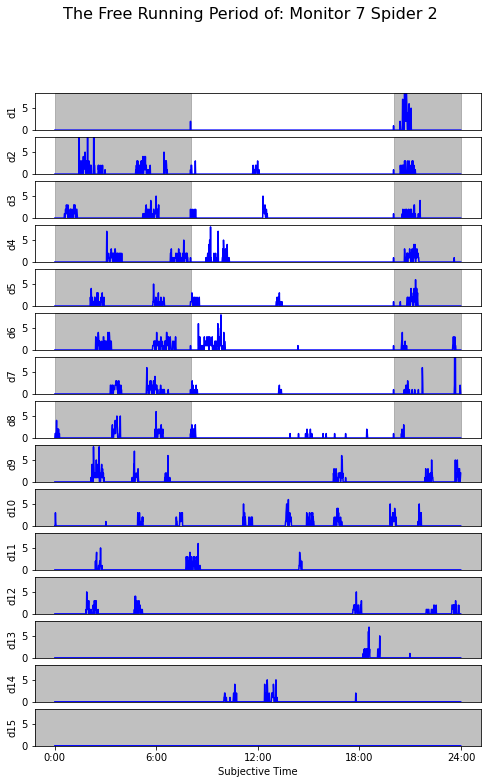

Next spider
Monitor 7 Spider 3


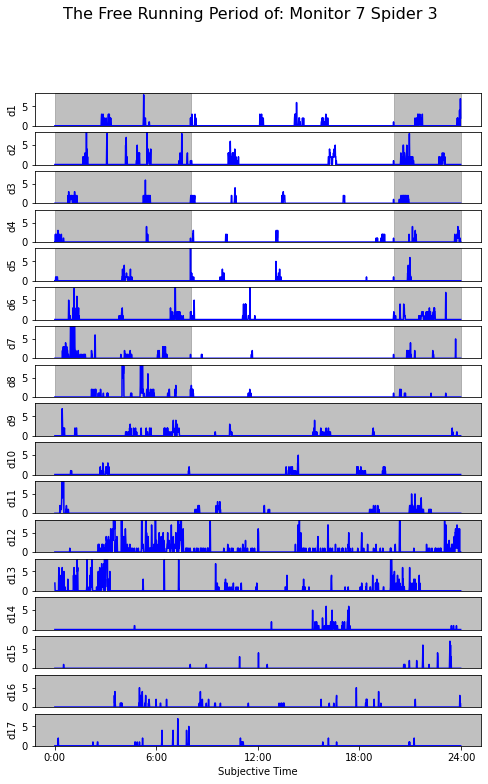

Next spider
Monitor 7 Spider 6


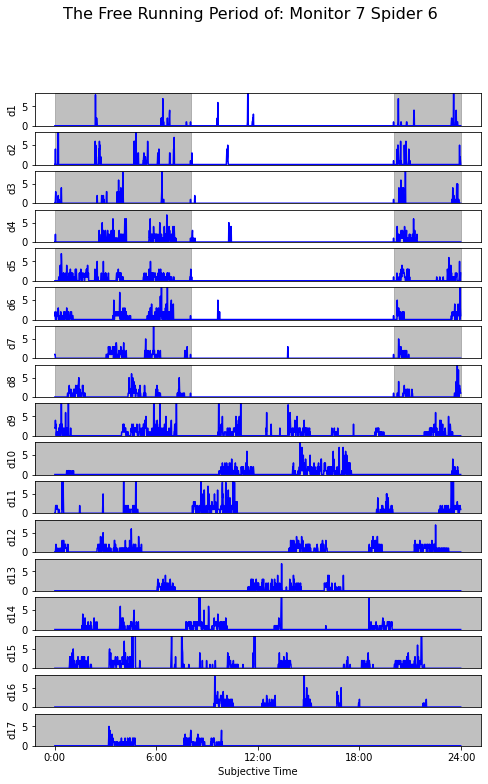

Next spider
Monitor 7 Spider 10


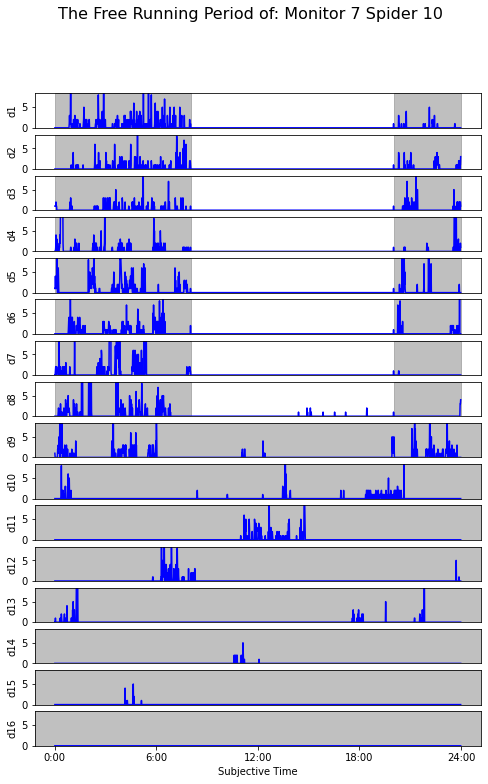

Next spider
Monitor 7 Spider 11


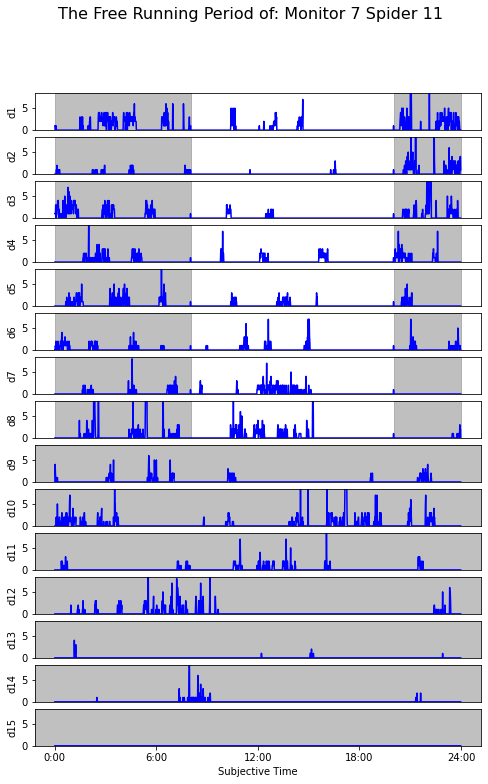

Next spider
Monitor 7 Spider 13


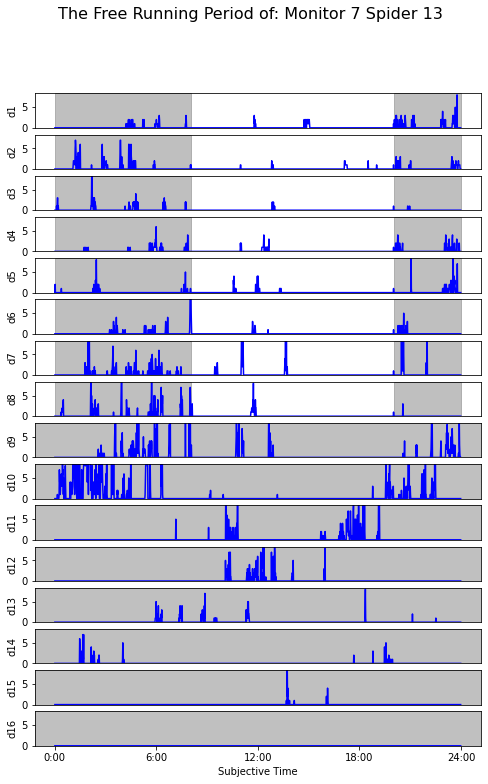

Next spider
Monitor 7 Spider 14


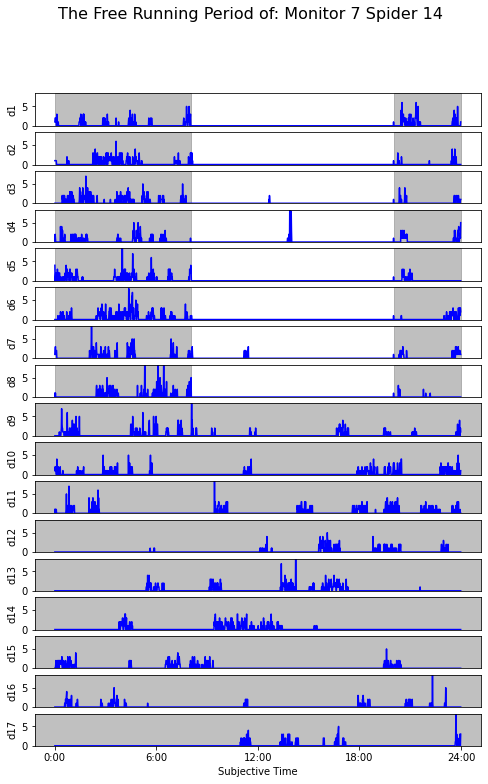

Next spider
Monitor 7 Spider 18


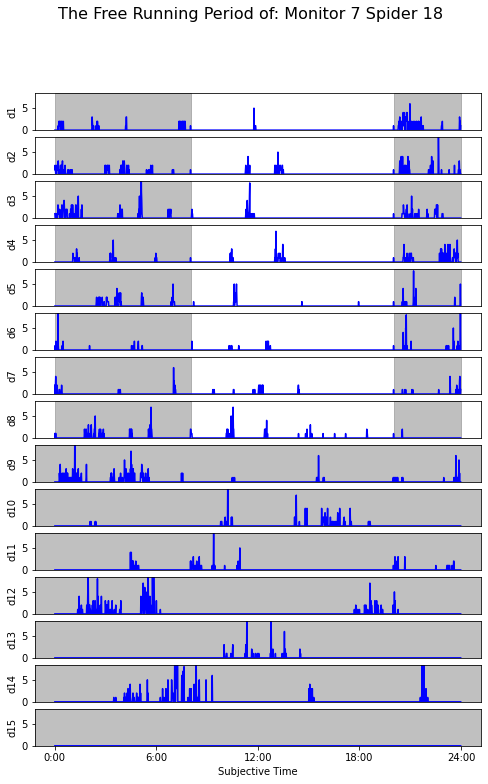

Next spider
Monitor 7 Spider 20


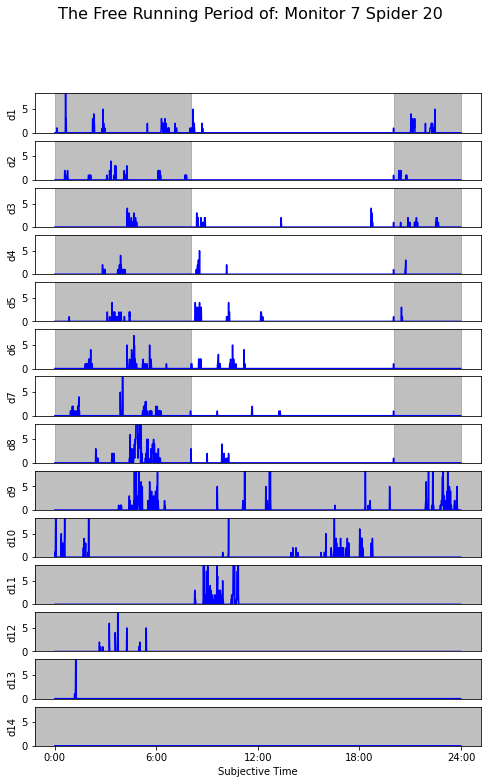

Next spider
Monitor 7 Spider 21


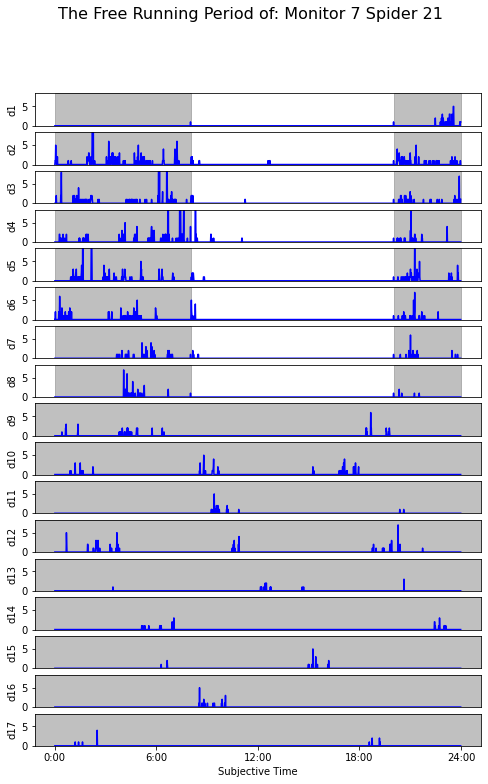

Next spider
Monitor 7 Spider 22


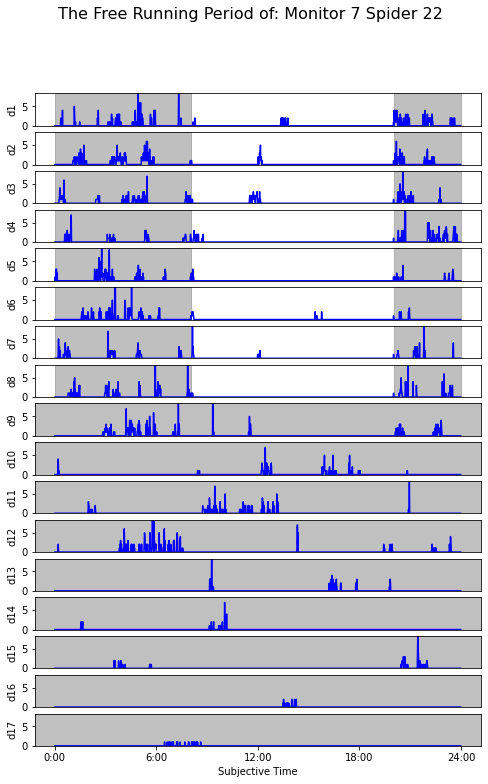

Next spider
Monitor 7 Spider 25


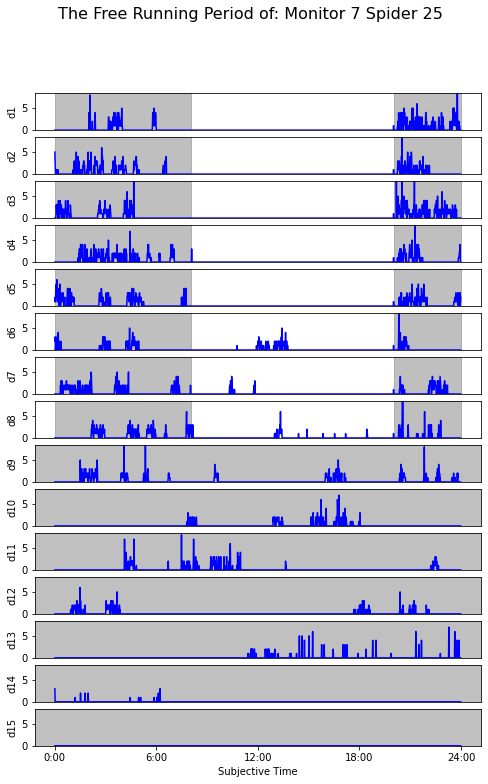

Next spider
Monitor 7 Spider 26


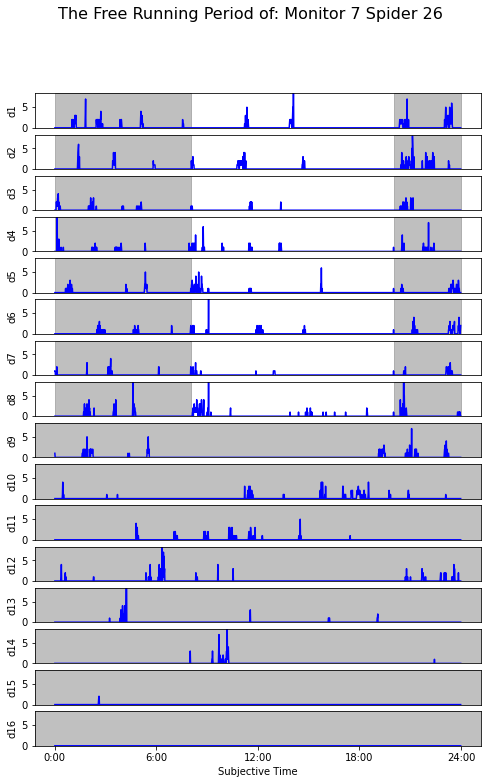

Next spider
Monitor 7 Spider 28


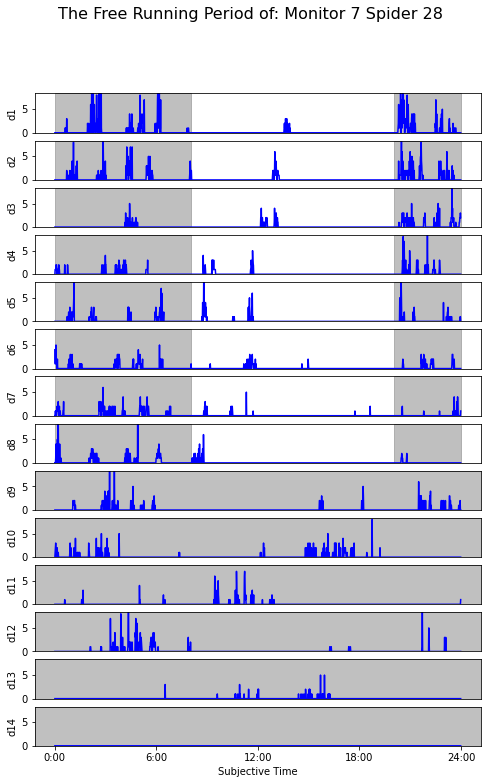

Next spider
Monitor 7 Spider 29


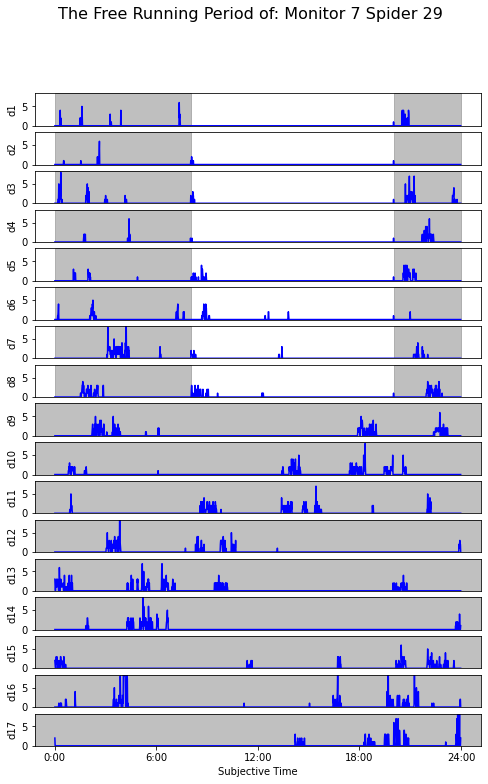

Next spider
Monitor 7 Spider 31


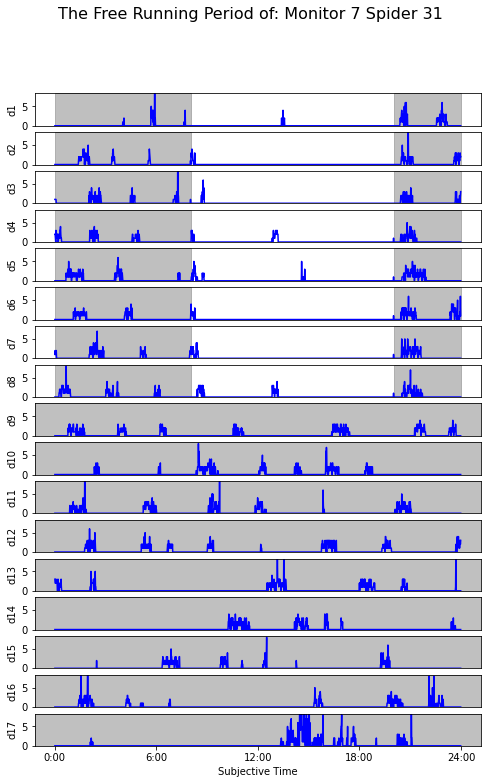

Next spider
Monitor 7 Spider 32


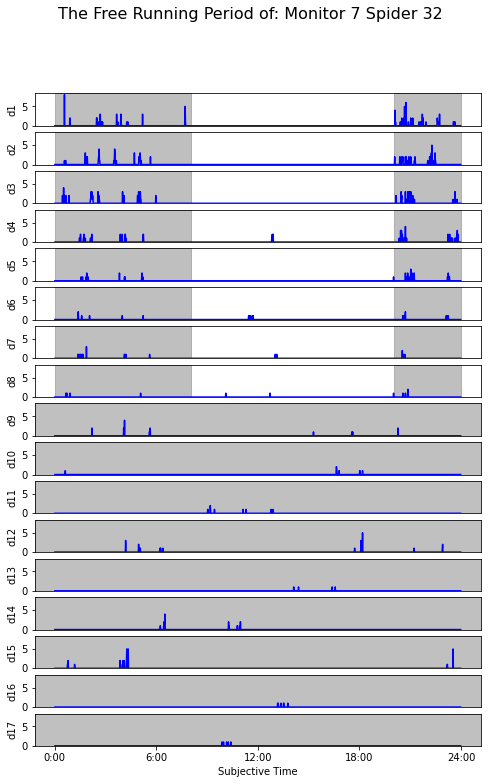

Next spider


In [10]:
spider_raster(dff)

['Monitor 7 Spider 2', 'Monitor 7 Spider 3', 'Monitor 7 Spider 6', 'Monitor 7 Spider 10', 'Monitor 7 Spider 11', 'Monitor 7 Spider 13', 'Monitor 7 Spider 14', 'Monitor 7 Spider 18', 'Monitor 7 Spider 20', 'Monitor 7 Spider 21', 'Monitor 7 Spider 22', 'Monitor 7 Spider 25', 'Monitor 7 Spider 26', 'Monitor 7 Spider 28', 'Monitor 7 Spider 29', 'Monitor 7 Spider 31', 'Monitor 7 Spider 32']
17


Period   Amplitude       p value
Spider                                                  
Monitor 7 Spider 2   18.539802   22.659238  1.771318e-05
Monitor 7 Spider 3   18.253474   51.022424  1.643310e-17
Monitor 7 Spider 6   17.979955  148.632687  1.138405e-59
Monitor 7 Spider 10  18.921011   75.291718  5.117330e-28
Monitor 7 Spider 11  17.945622   74.021763  1.580865e-27

Monitor 7 Spider 2
Next spider
Monitor 7 Spider 3
Next spider
Monitor 7 Spider 6
Next spider
Monitor 7 Spider 10
Next spider
Monitor 7 Spider 11
Next spider
Monitor 7 Spider 13
Next spider
Monitor 7 Spider 14
Next spider
Monitor 7 Spider 18
Next spider
Monitor 7 Spider 20
Next spider
Monitor 7 Spider 21
Next spider
Monitor 7 Spider 22
Next spider
Monitor 7 Spider 25
Next spider
Monitor 7 Spider 26
Next spider
Monitor 7 Spider 28
Next spider
Monitor 7 Spider 29
Next spider
Monitor 7 Spider 31
Next spider
Monitor 7 Spider 32
Next spider


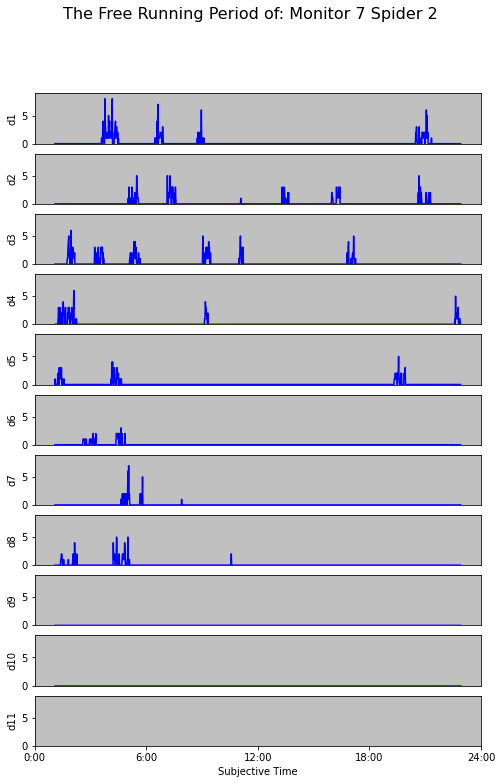

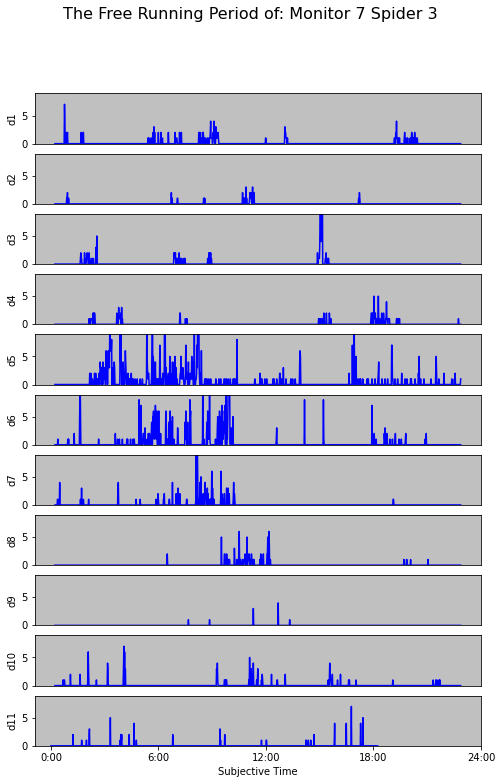

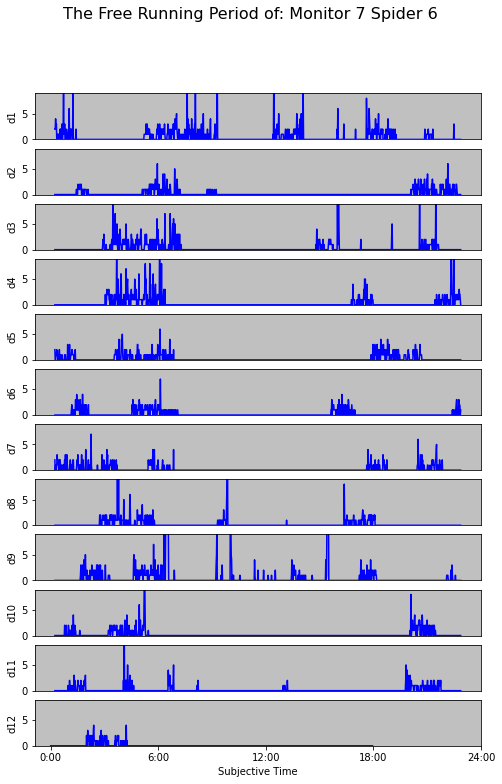

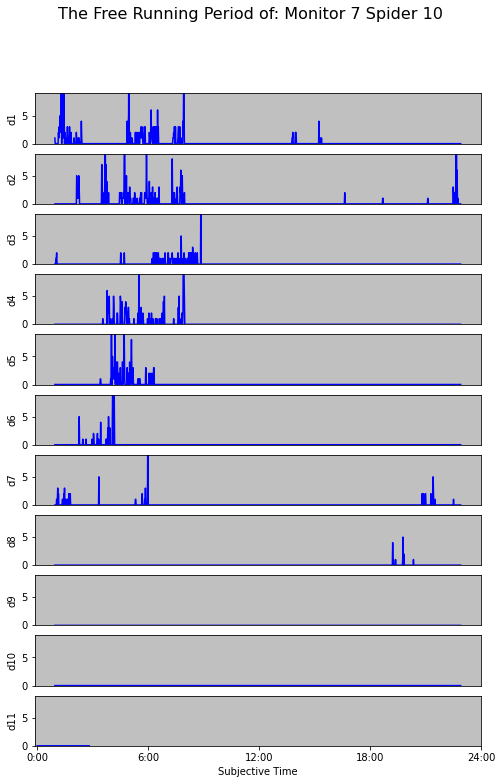

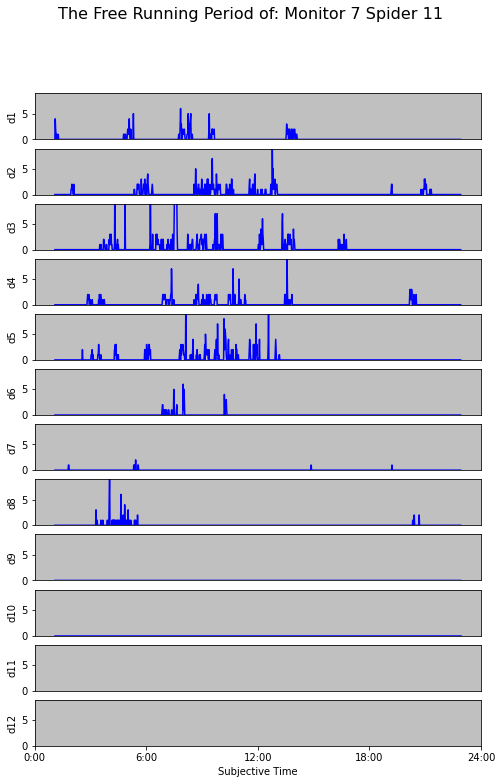

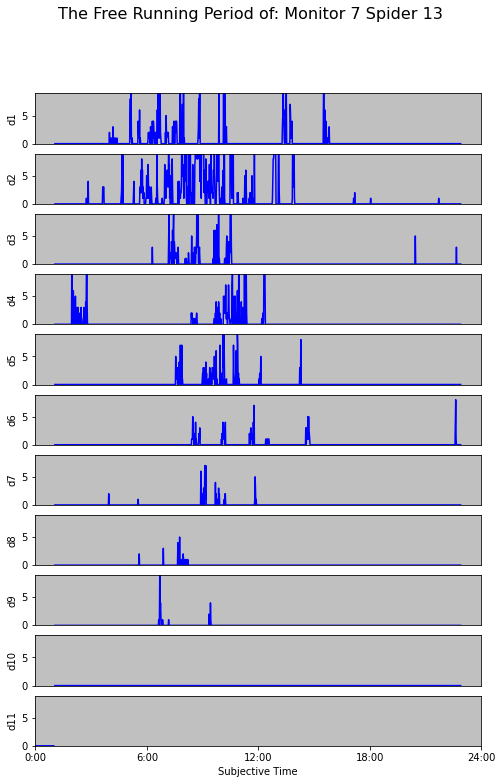

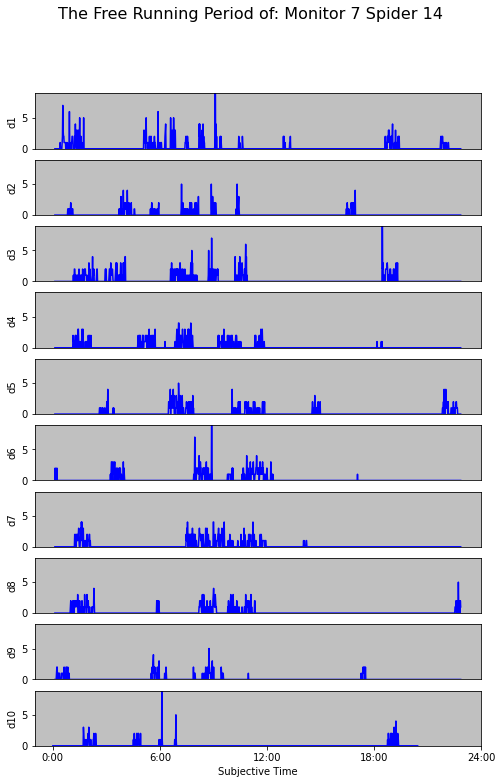

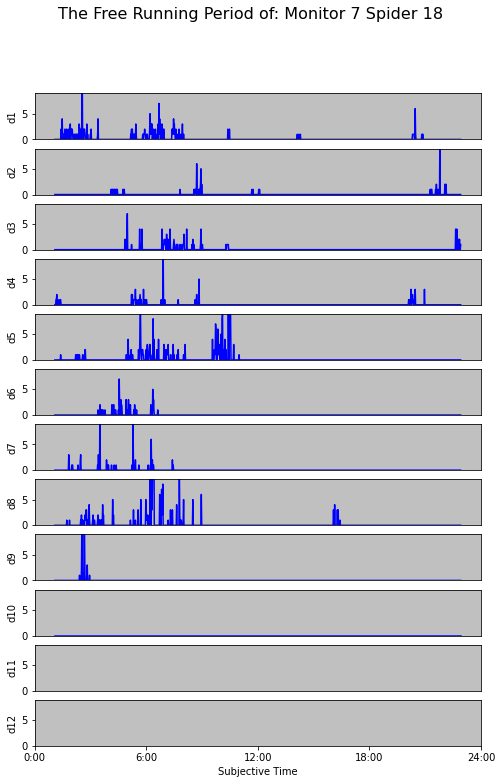

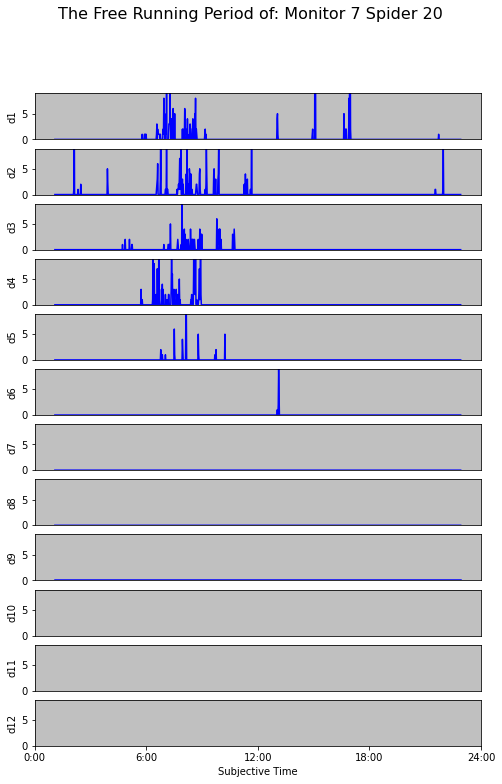

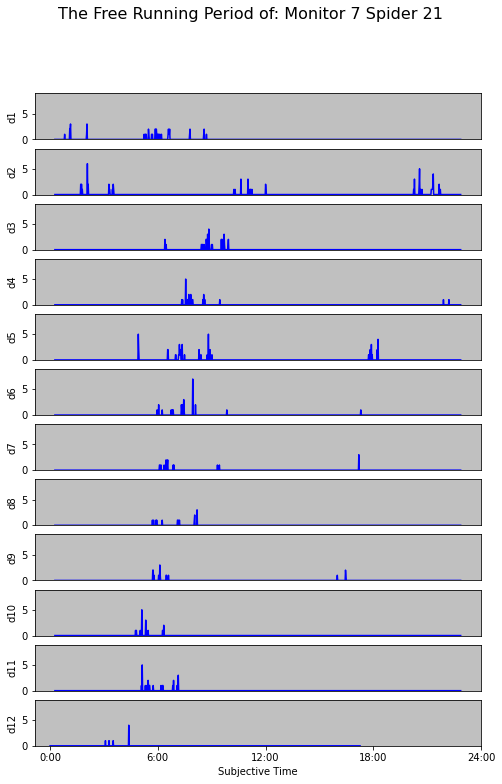

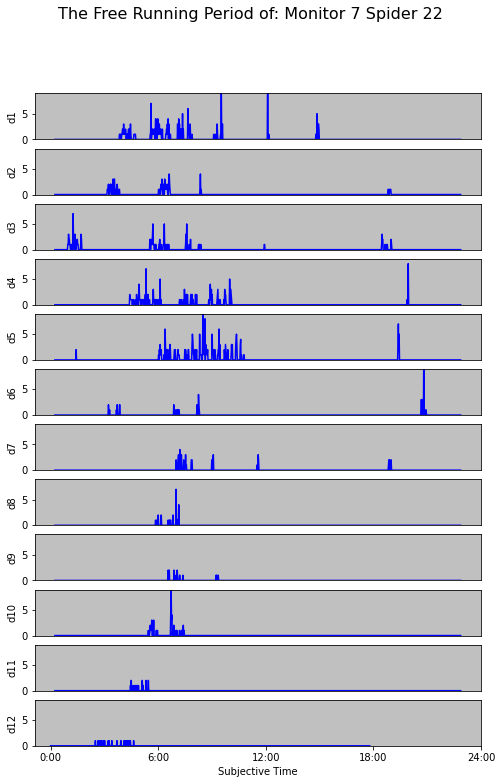

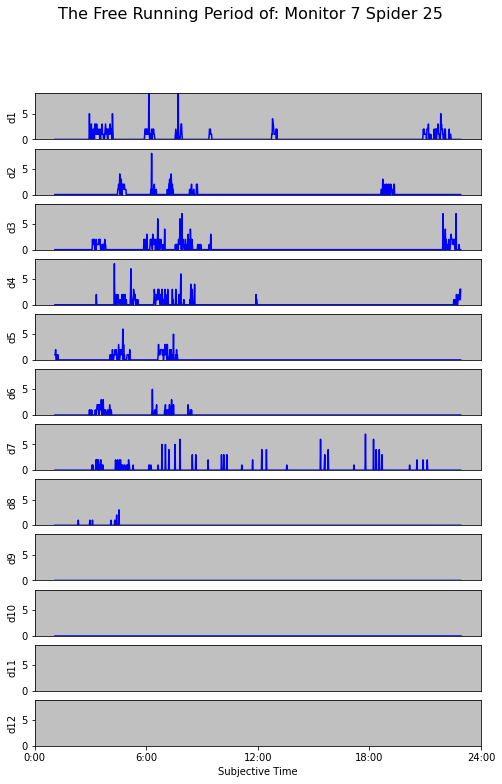

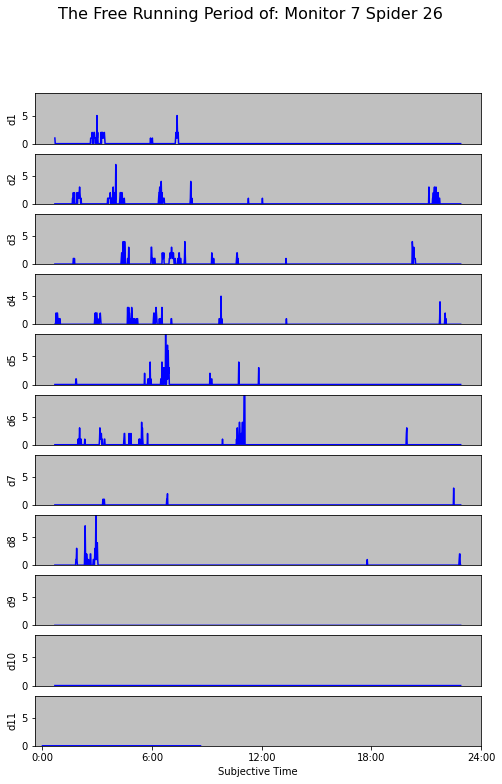

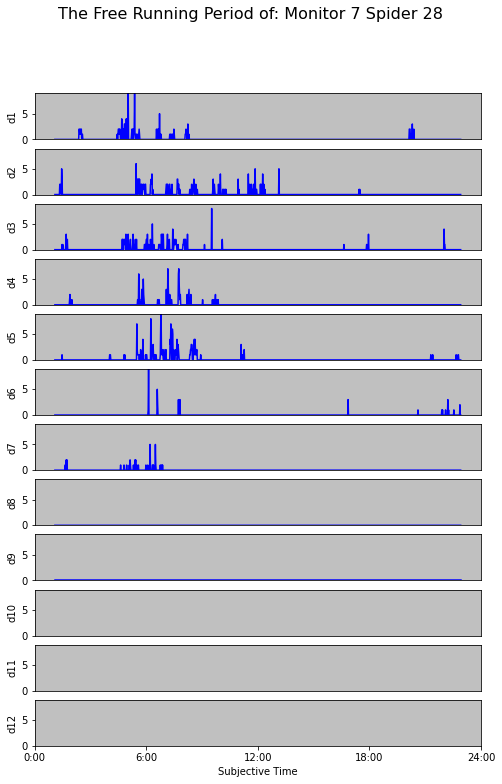

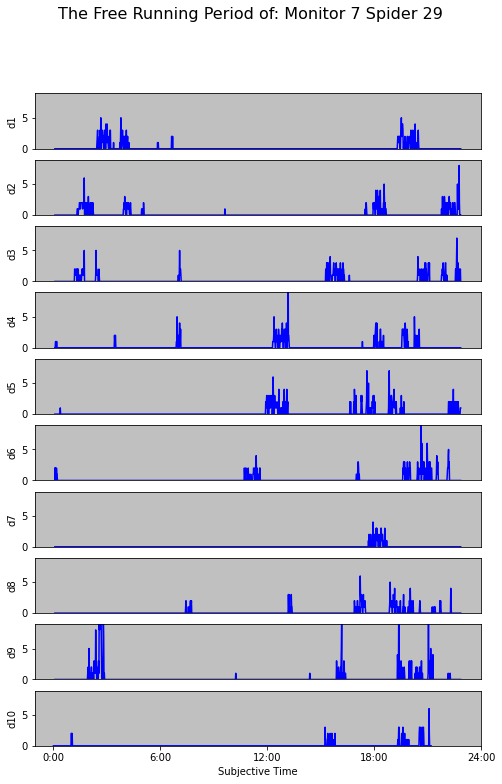

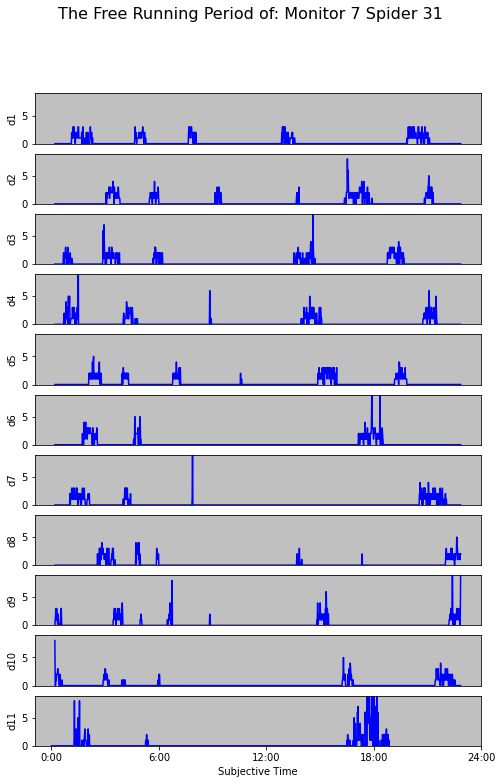

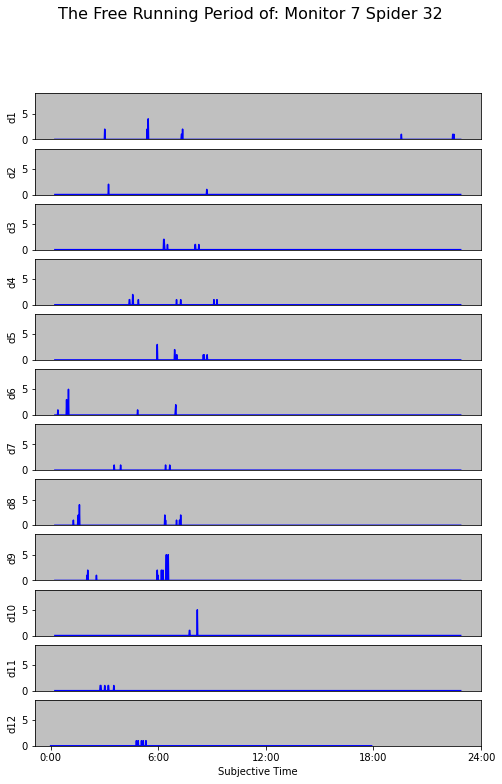

In [11]:
spider_datafile_base = "Cyclosa Turbinata Monitor 7 Updated_DD"                        
df_out = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
df_out = df_out.set_index('Spider') 
outfile = spider_datafile_base + '_Stats.csv'
#df_out.to_csv(outfile)            
display(df_out.head())  

percyc=df_out.loc[:,['Period']]
spider_raster_per(df2, percyc)

## FRONTINELLA

In [12]:
dfr1=pd.read_csv('Frontinella Pyramitela Monitor 11_LD.csv', index_col=0)
dfr2=pd.read_csv('Frontinella Pyramitela Monitor 11_DD.csv', index_col=0)
dfr2=dfr2.drop(['Monitor 11 Spider 6','Monitor 11 Spider 9','Monitor 11 Spider 16'], axis=1)
dfr = pd.concat([dfr1,dfr2])
#display(dfr)

Monitor 11 Spider 1


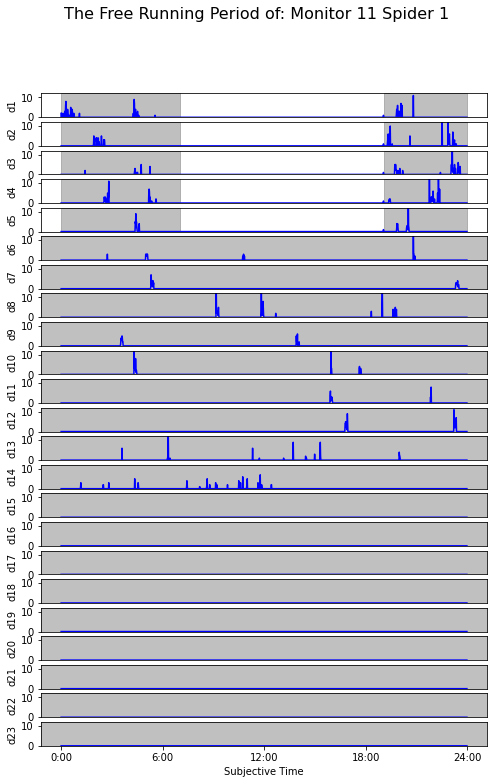

Next spider
Monitor 11 Spider 2


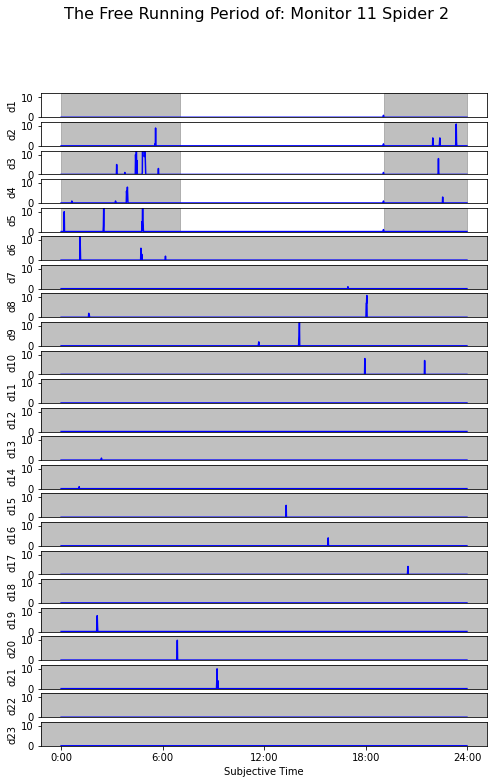

Next spider
Monitor 11 Spider 3


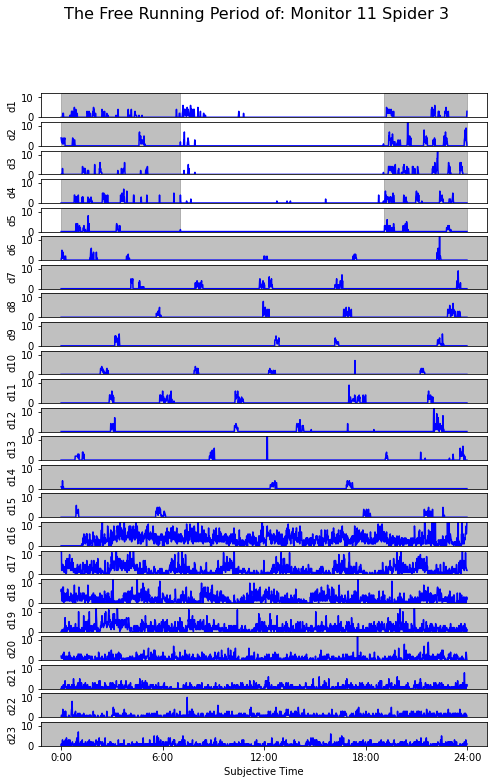

Next spider
Monitor 11 Spider 4


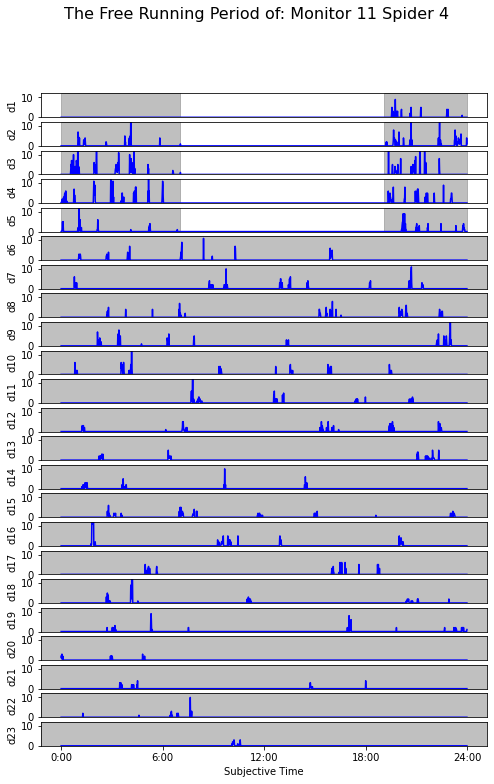

Next spider
Monitor 11 Spider 5


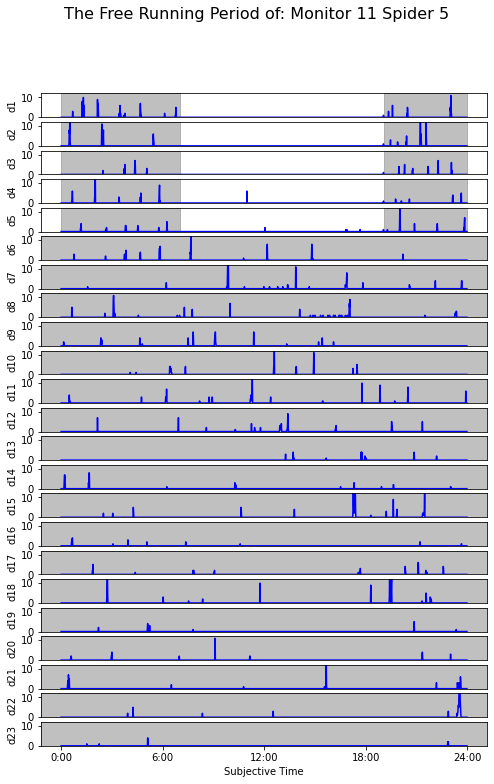

Next spider
Monitor 11 Spider 6


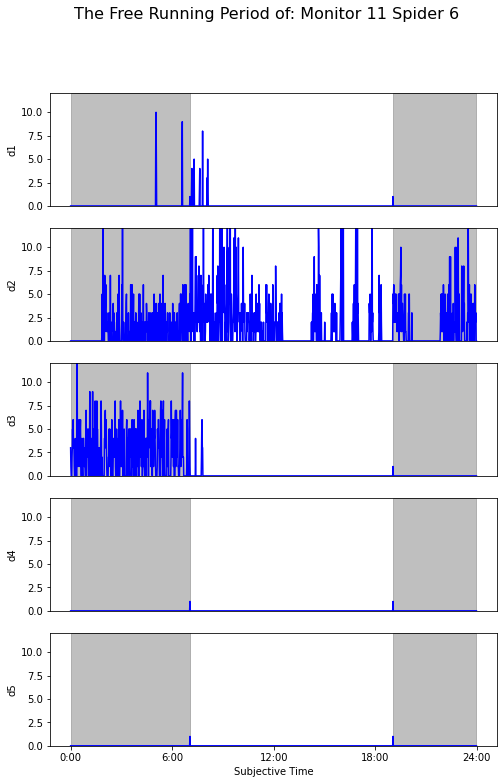

Next spider
Monitor 11 Spider 7


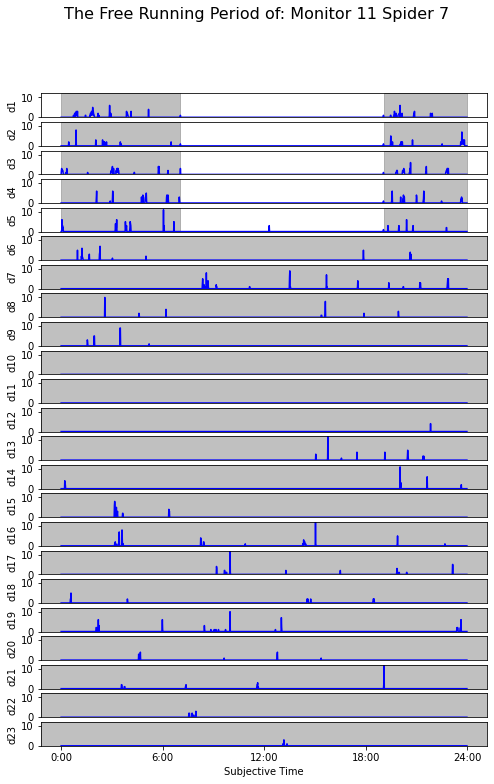

Next spider
Monitor 11 Spider 8


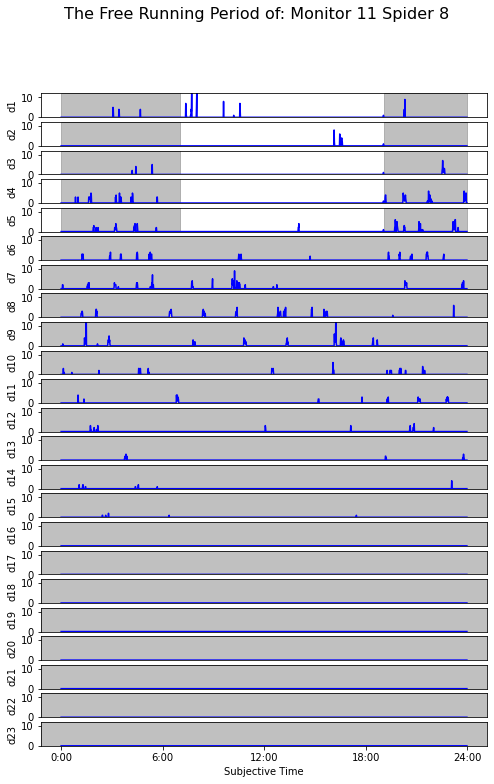

Next spider
Monitor 11 Spider 9


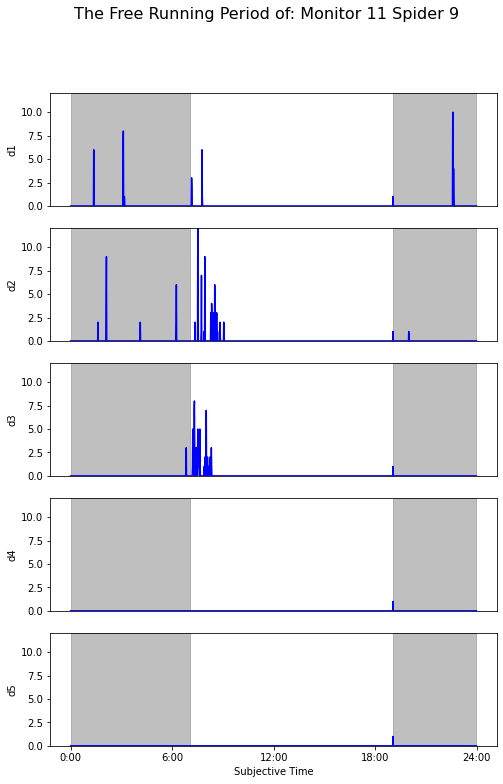

Next spider
Monitor 11 Spider 10


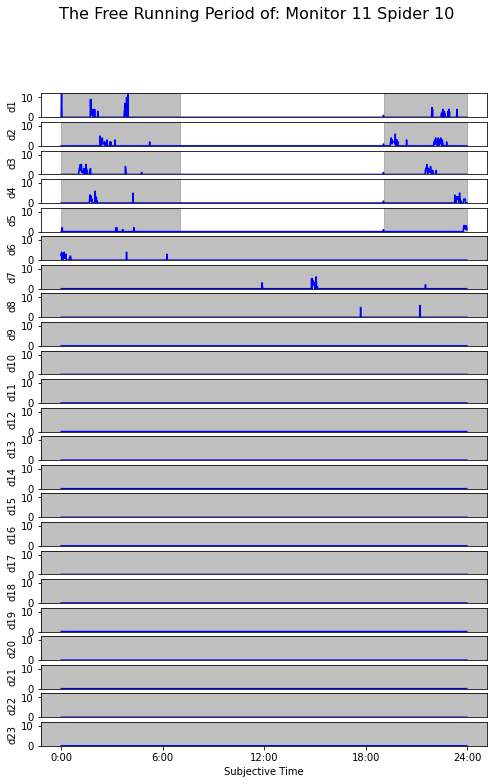

Next spider
Monitor 11 Spider 11


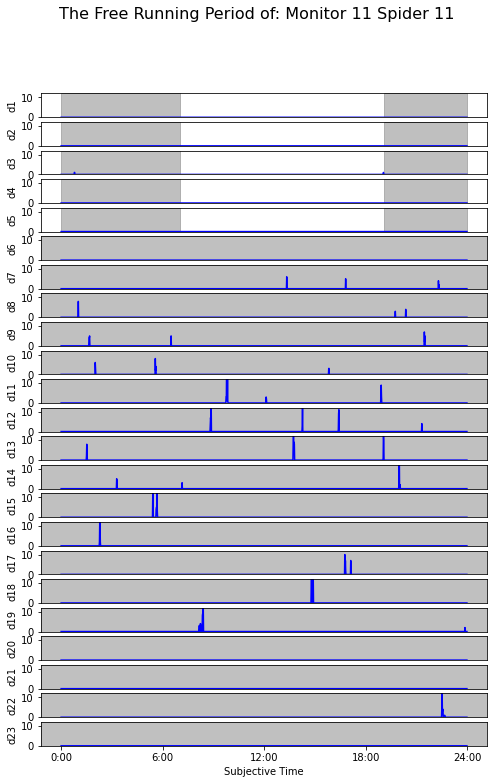

Next spider
Monitor 11 Spider 12


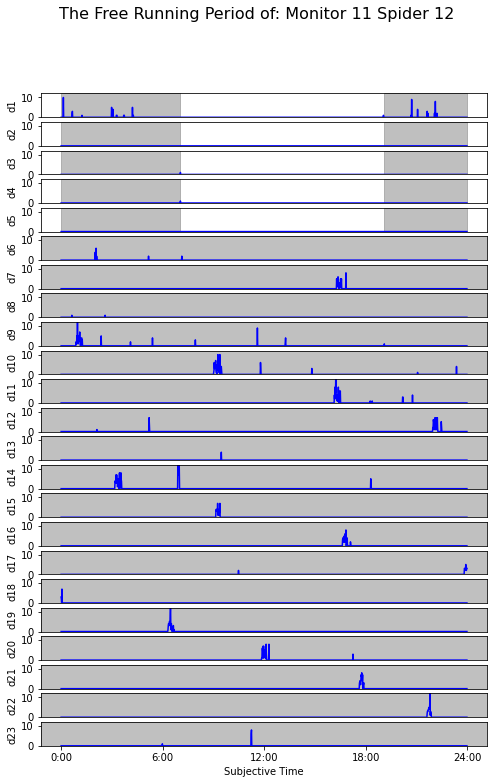

Next spider
Monitor 11 Spider 13


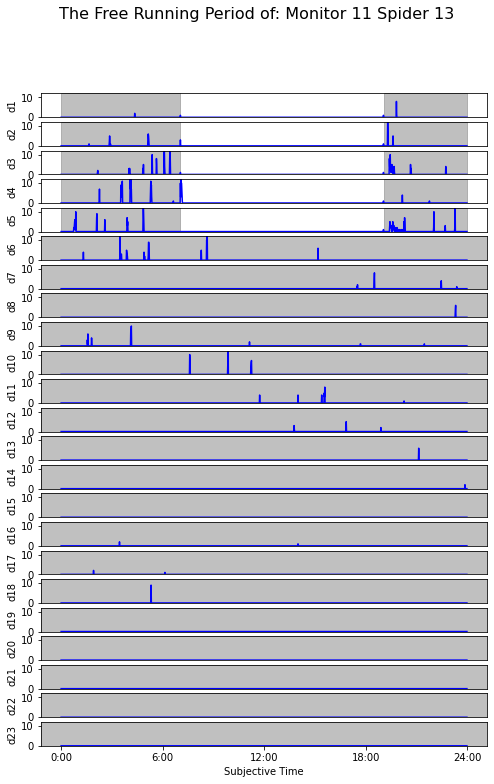

Next spider
Monitor 11 Spider 14


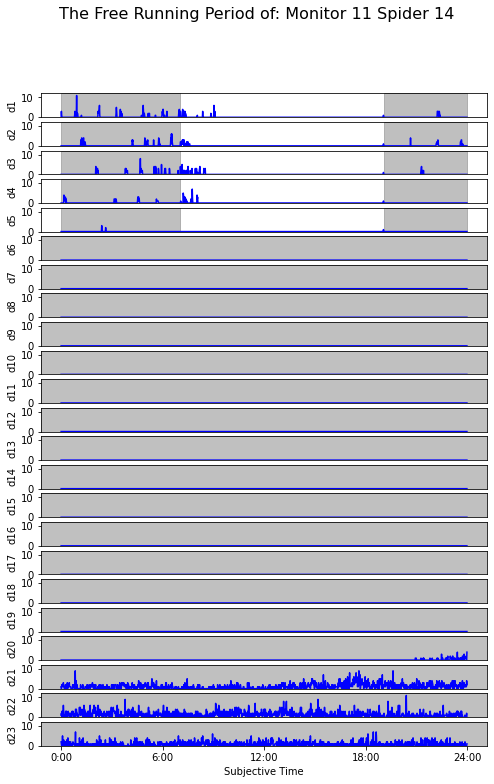

Next spider
Monitor 11 Spider 15


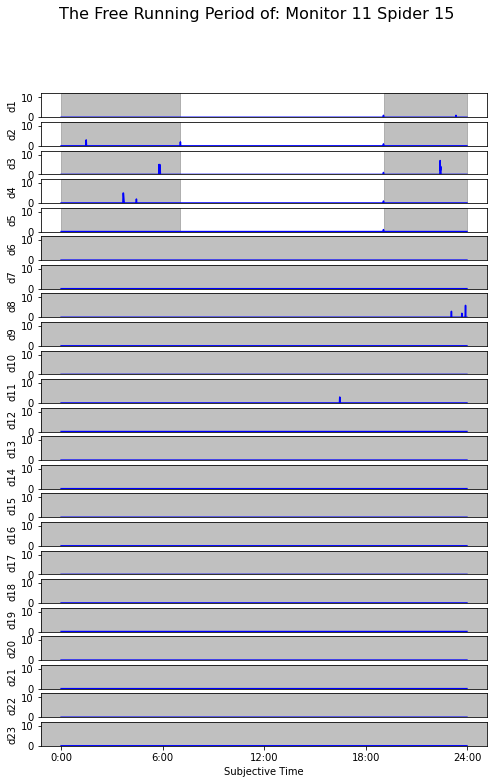

Next spider
Monitor 11 Spider 16


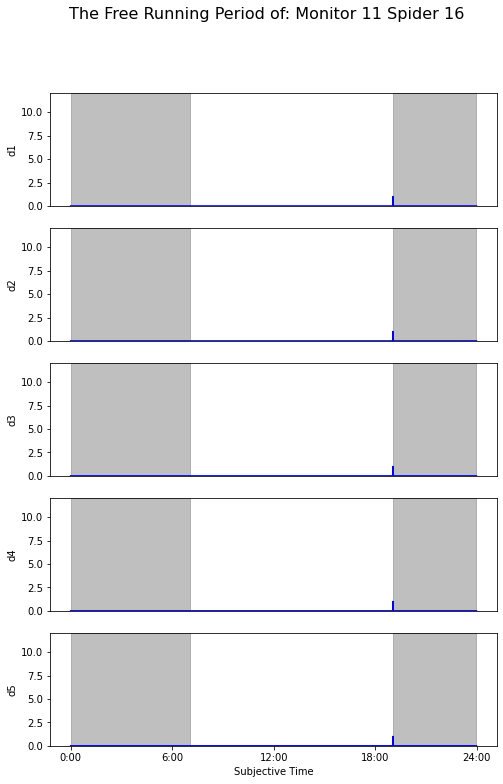

Next spider
Monitor 11 Spider 17


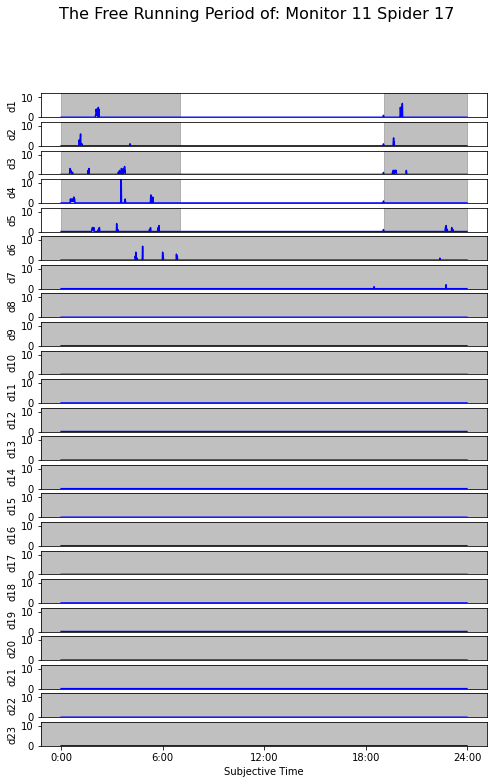

Next spider
Monitor 11 Spider 18


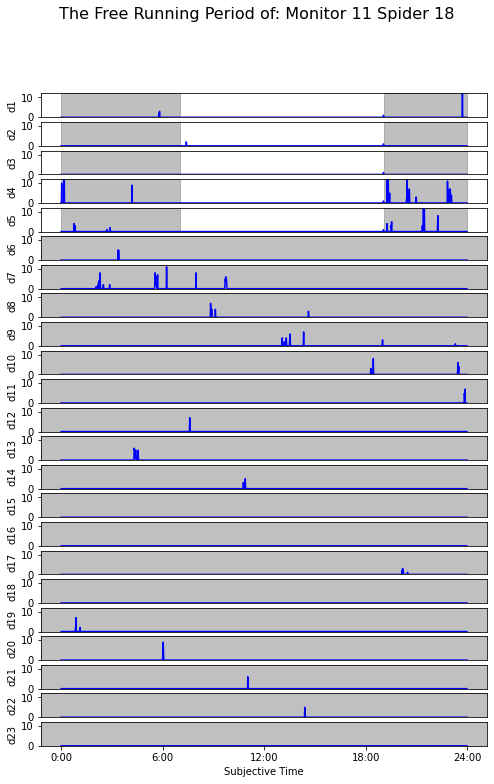

Next spider
Monitor 11 Spider 19


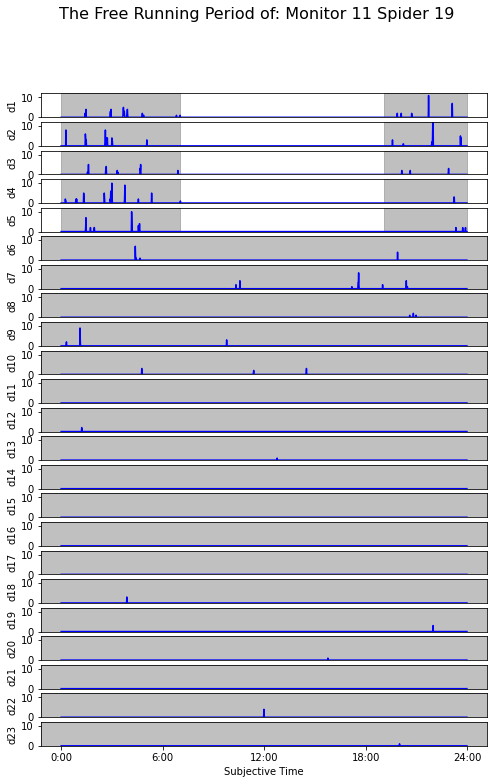

Next spider
Monitor 11 Spider 20


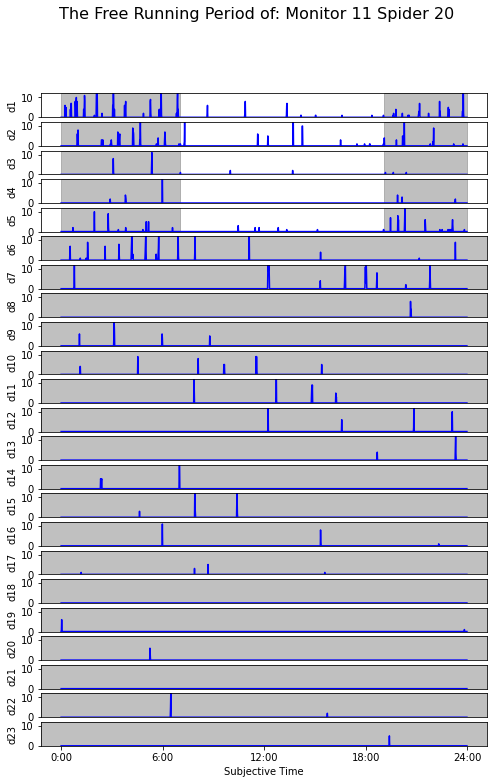

Next spider
Monitor 11 Spider 21


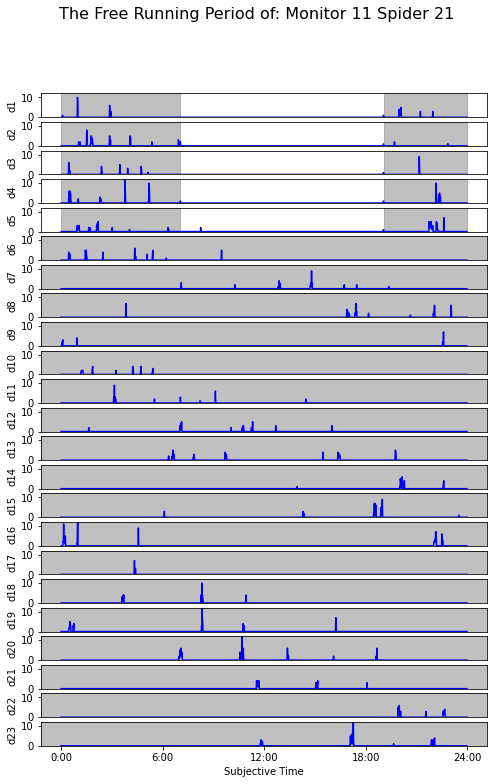

Next spider
Monitor 11 Spider 22


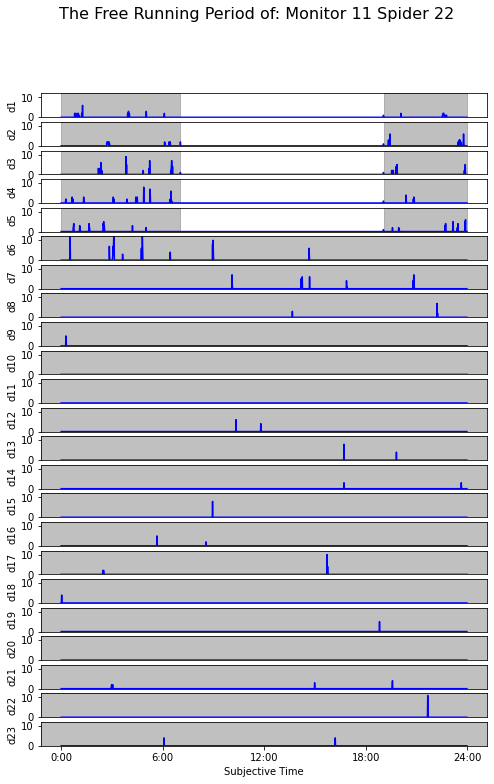

Next spider
Monitor 11 Spider 23


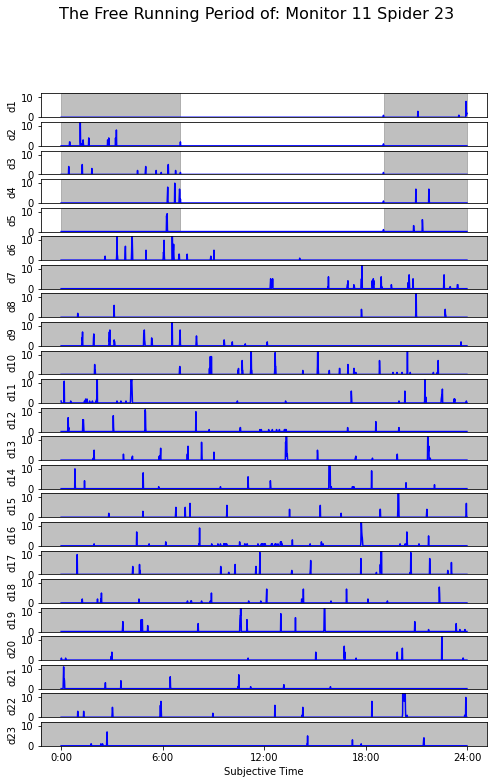

Next spider
Monitor 11 Spider 24


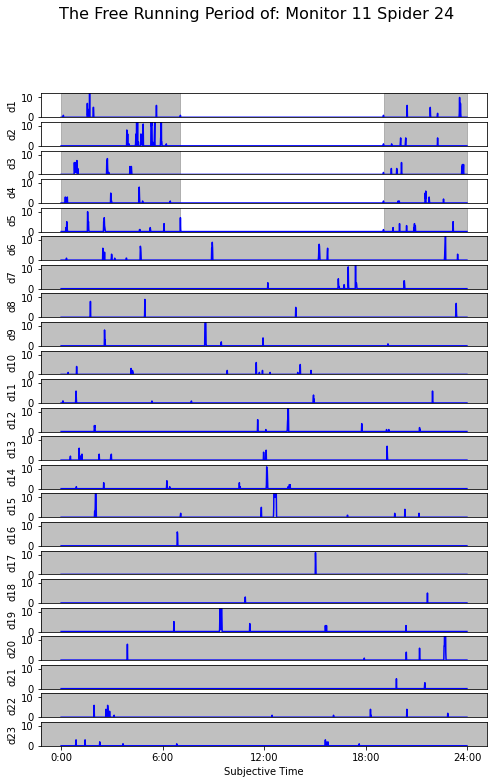

Next spider
Monitor 11 Spider 25


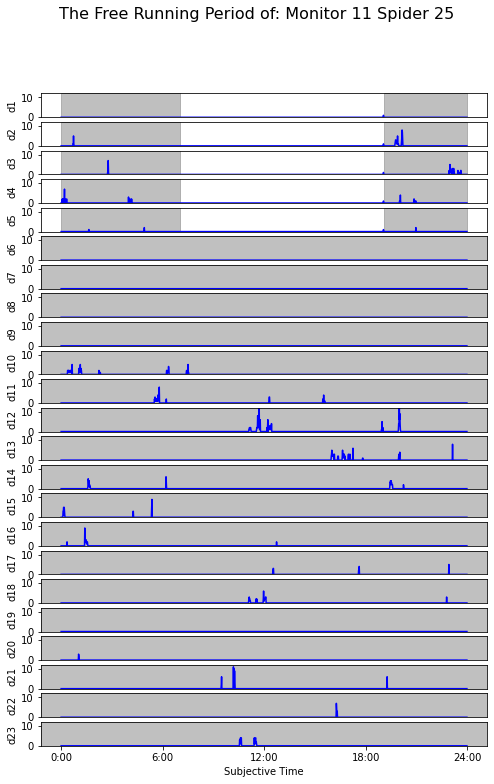

Next spider
Monitor 11 Spider 26


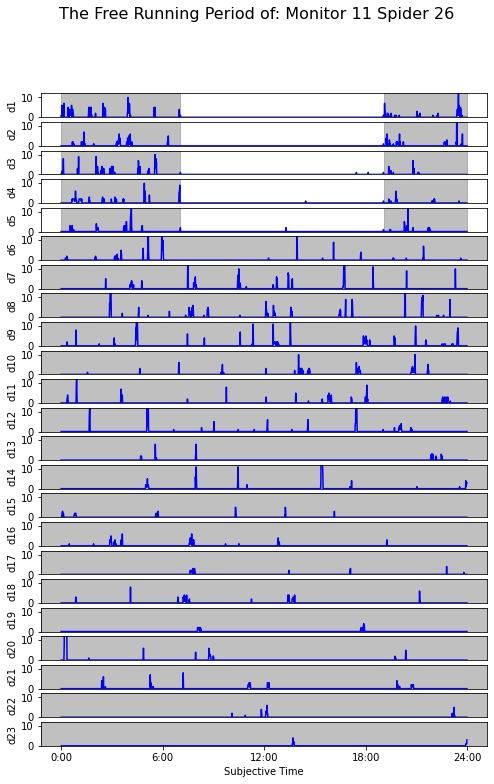

Next spider
Monitor 11 Spider 27


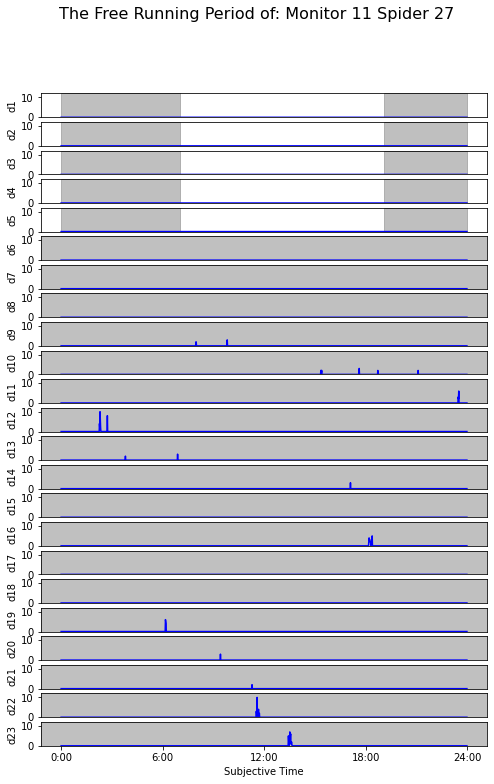

Next spider
Monitor 11 Spider 28


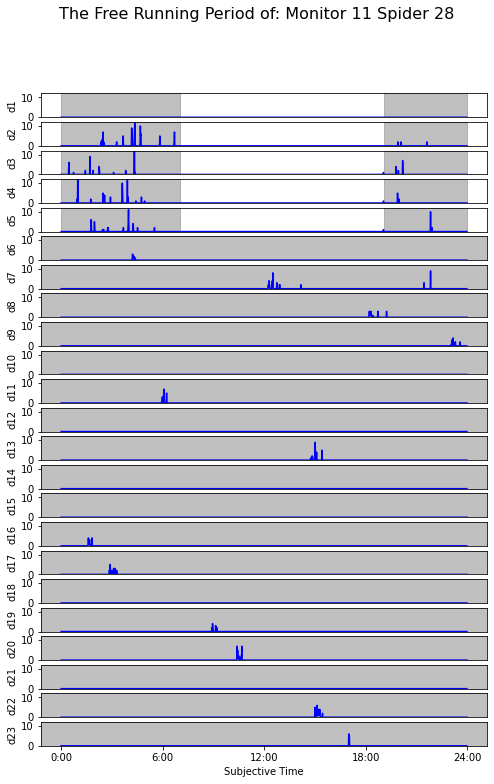

Next spider
Monitor 11 Spider 29


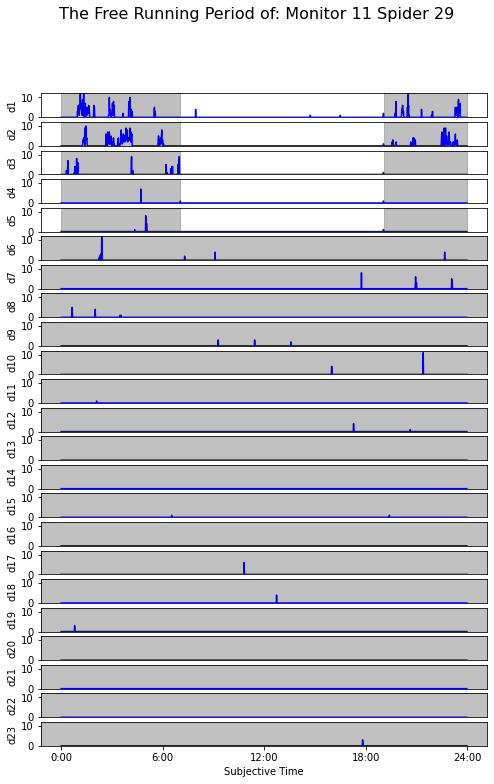

Next spider
Monitor 11 Spider 30


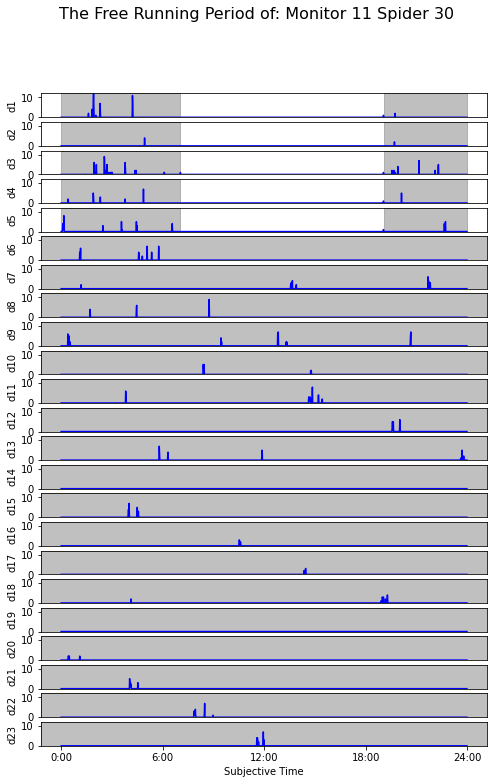

Next spider
Monitor 11 Spider 31


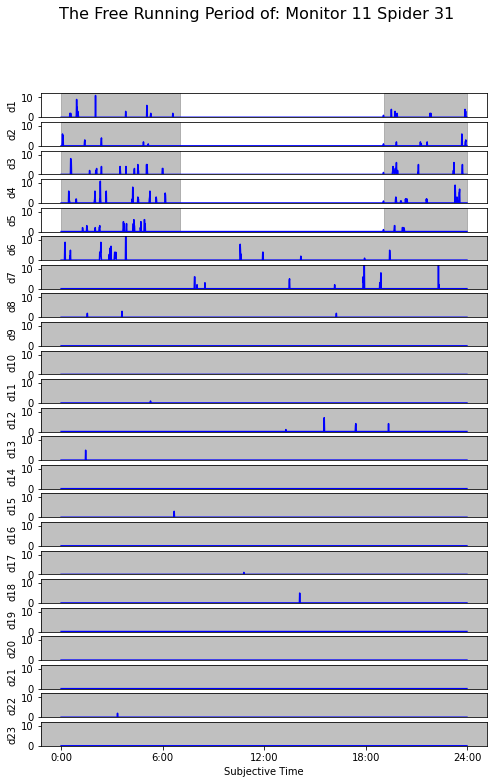

Next spider
Monitor 11 Spider 32


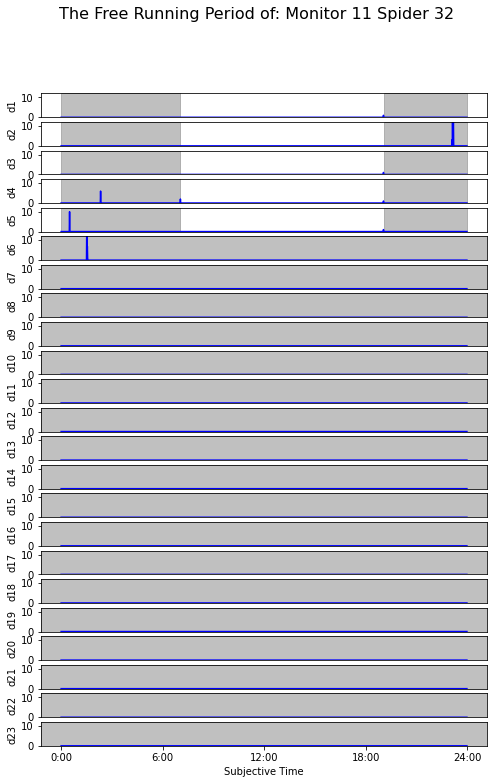

Next spider


In [13]:
spider_raster(dfr)

['Monitor 11 Spider 1', 'Monitor 11 Spider 2', 'Monitor 11 Spider 3', 'Monitor 11 Spider 4', 'Monitor 11 Spider 5', 'Monitor 11 Spider 6', 'Monitor 11 Spider 7', 'Monitor 11 Spider 8', 'Monitor 11 Spider 9', 'Monitor 11 Spider 10', 'Monitor 11 Spider 11', 'Monitor 11 Spider 12', 'Monitor 11 Spider 13', 'Monitor 11 Spider 14', 'Monitor 11 Spider 15', 'Monitor 11 Spider 16', 'Monitor 11 Spider 17', 'Monitor 11 Spider 18', 'Monitor 11 Spider 19', 'Monitor 11 Spider 20', 'Monitor 11 Spider 21', 'Monitor 11 Spider 22', 'Monitor 11 Spider 23', 'Monitor 11 Spider 24', 'Monitor 11 Spider 25', 'Monitor 11 Spider 26', 'Monitor 11 Spider 27', 'Monitor 11 Spider 28', 'Monitor 11 Spider 29', 'Monitor 11 Spider 30', 'Monitor 11 Spider 31', 'Monitor 11 Spider 32']
32


Period   Amplitude       p value
Spider                                                   
Monitor 11 Spider 1   34.000000    1.157507  1.000000e+00
Monitor 11 Spider 2   28.187424    0.590841  1.000000e+00
Monitor 11 Spider 3   22.705620  136.395004  4.502036e-54
Monitor 11 Spider 4   29.455969    9.191561  1.000000e+00
Monitor 11 Spider 5   25.020187   16.663638  1.556557e-02
Monitor 11 Spider 6    0.000000    0.000000  1.000000e+00
Monitor 11 Spider 7   15.048857    1.575582  1.000000e+00
Monitor 11 Spider 8   27.400735    3.379457  1.000000e+00
Monitor 11 Spider 9    0.000000    0.000000  1.000000e+00
Monitor 11 Spider 10  34.000000    0.409584  1.000000e+00
Monitor 11 Spider 11  27.968428    2.740654  1.000000e+00
Monitor 11 Spider 12  30.367060   31.076423  1.178975e-08
Monitor 11 Spider 13  32.033428    1.939160  1.000000e+00
Monitor 11 Spider 14  16.649713   15.744977  3.749309e-02
Monitor 11 Spider 15  21.485944    0.011122  1.000000e+00
Monitor 11 Spider 16   0.000000    0.000000  1.000000e+00
Monitor 11 Spider 17  19.577415    0.038810  1.000000e+00
Monitor 11 Spider 18  28.409878    3.478656  1.000000e+00
Monitor 11 Spider 19  32.418058    0.142784  1.000000e+00
Monitor 11 Spider 20  31.473296   10.897067  9.826218e-01
Monitor 11 Spider 21  27.932259   14.175125  1.599201e-01
Monitor 11 Spider 22  30.668889    1.182893  1.000000e+00
Monitor 11 Spider 23  16.534999   17.823285  5.075088e-03
Monitor 11 Spider 24  31.110633   12.650067  5.306870e-01
Monitor 11 Spider 25  29.415853    6.888600  1.000000e+00
Monitor 11 Spider 26  21.944360   18.658104  2.256524e-03
Monitor 11 Spider 27  27.860200    0.743836  1.000000e+00
Monitor 11 Spider 28  27.968428    2.002874  1.000000e+00
Monitor 11 Spider 29  22.516263    0.217682  1.000000e+00
Monitor 11 Spider 30  14.329995    1.817168  1.000000e+00
Monitor 11 Spider 31  31.985990    0.746444  1.000000e+00
Monitor 11 Spider 32  33.629439    0.030773  1.000000e+00

Monitor 11 Spider 1
Next spider
Monitor 11 Spider 2
Next spider
Monitor 11 Spider 3
Next spider
Monitor 11 Spider 4
Next spider
Monitor 11 Spider 5
Next spider
Monitor 11 Spider 7
Next spider
Monitor 11 Spider 8
Next spider
Monitor 11 Spider 10
Next spider
Monitor 11 Spider 11
Next spider
Monitor 11 Spider 12
Next spider
Monitor 11 Spider 13
Next spider
Monitor 11 Spider 14
Next spider
Monitor 11 Spider 15
Next spider
Monitor 11 Spider 17
Next spider
Monitor 11 Spider 18
Next spider
Monitor 11 Spider 19
Next spider
Monitor 11 Spider 20
Next spider
Monitor 11 Spider 21
Next spider
Monitor 11 Spider 22
Next spider
Monitor 11 Spider 23
Next spider
Monitor 11 Spider 24


<ipython-input-2-cf8a2c878353>:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(num_days,1, figsize=(8,12), sharey=True)


Next spider
Monitor 11 Spider 25
Next spider
Monitor 11 Spider 26
Next spider
Monitor 11 Spider 27
Next spider
Monitor 11 Spider 28
Next spider
Monitor 11 Spider 29
Next spider
Monitor 11 Spider 30
Next spider
Monitor 11 Spider 31
Next spider
Monitor 11 Spider 32
Next spider


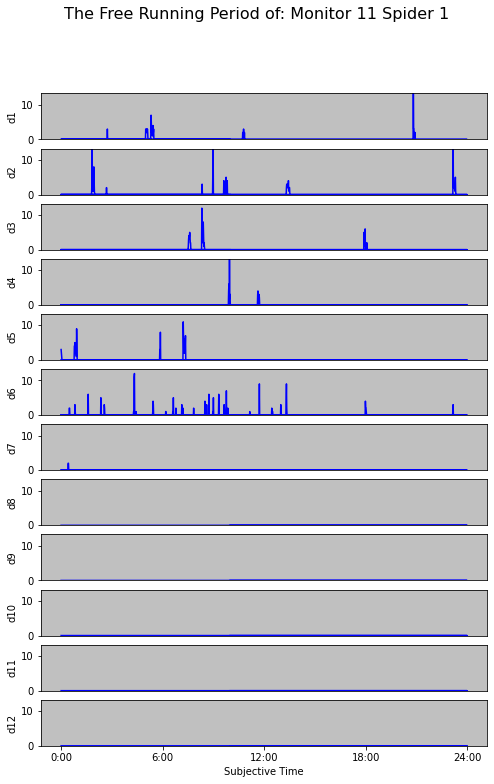

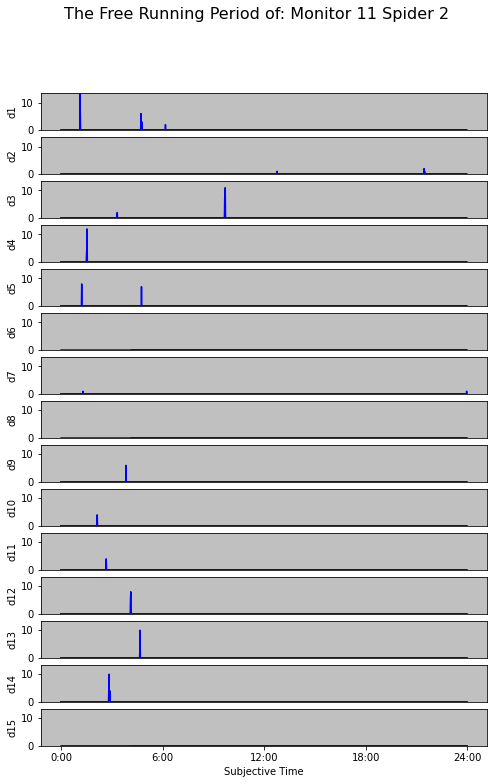

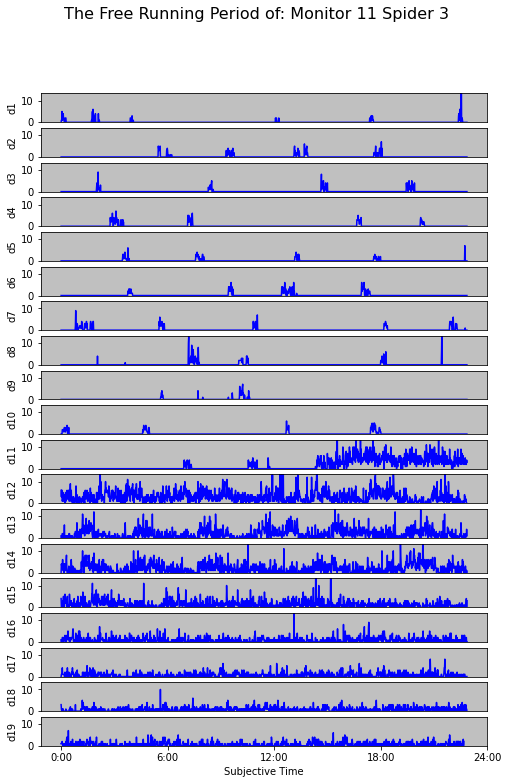

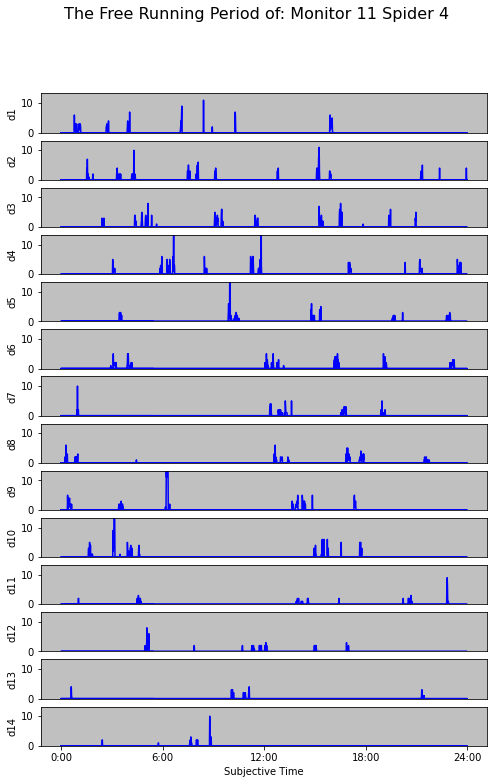

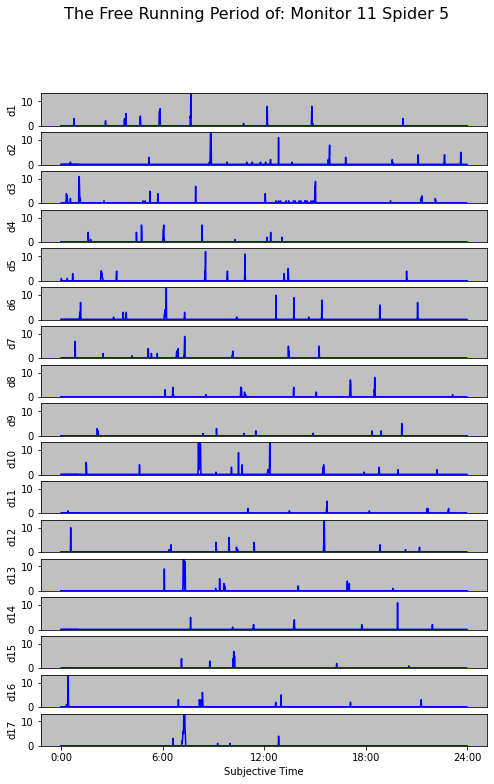

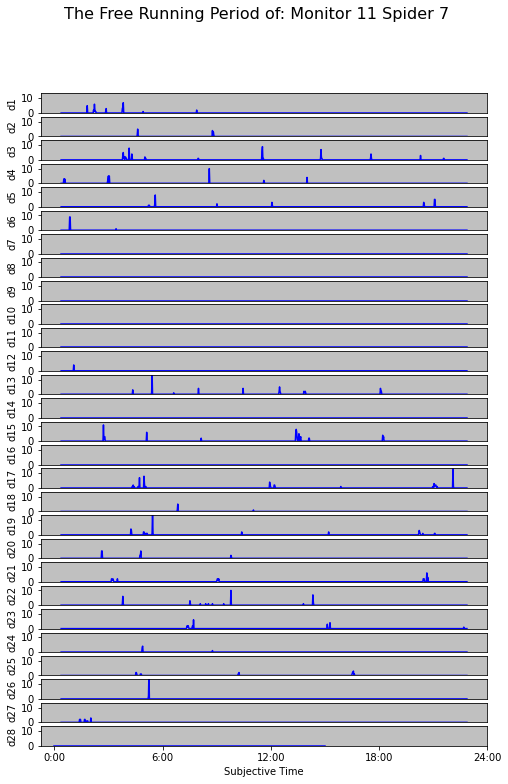

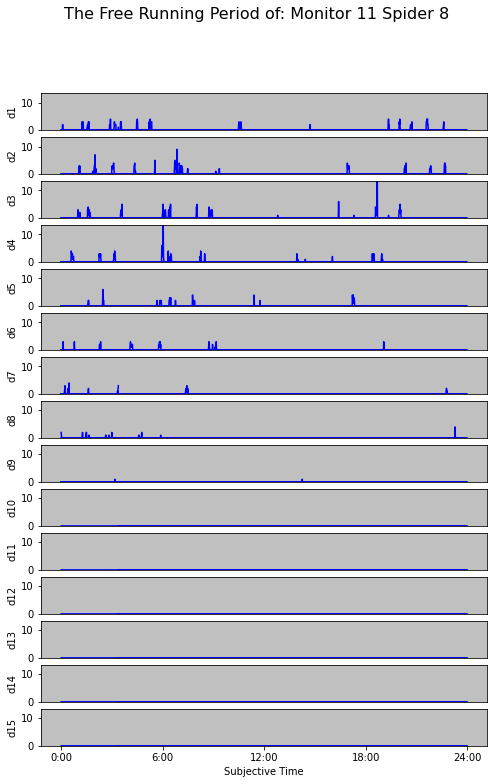

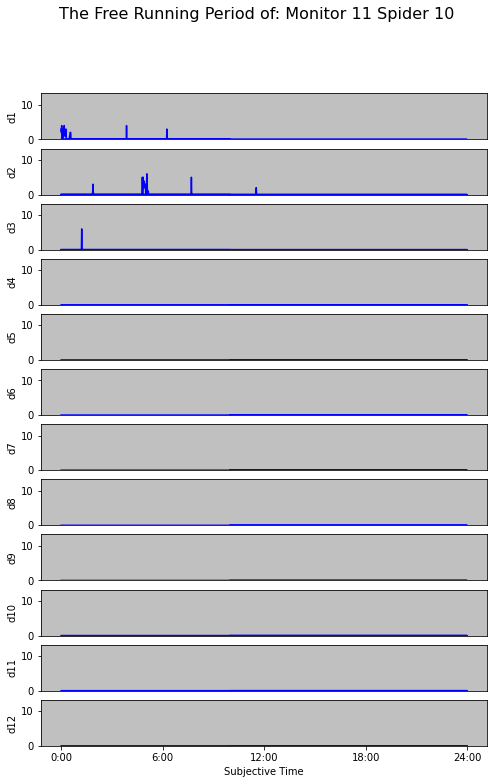

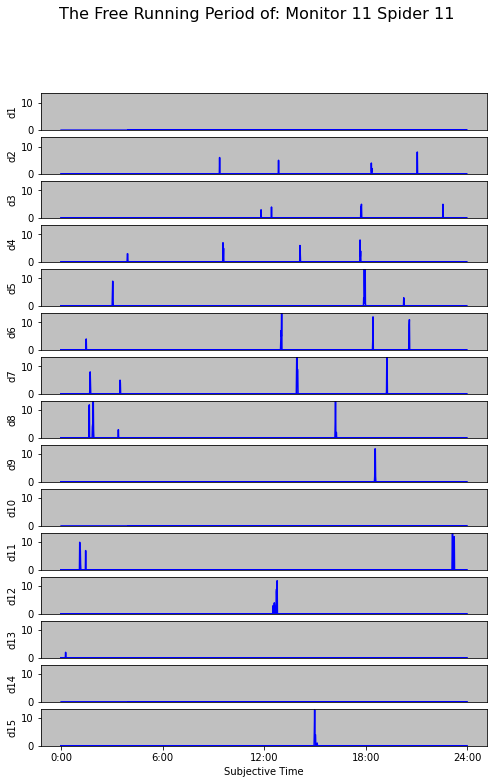

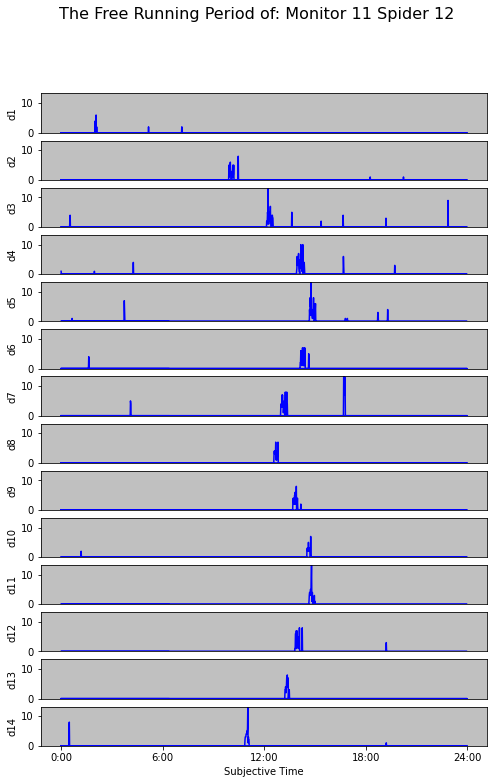

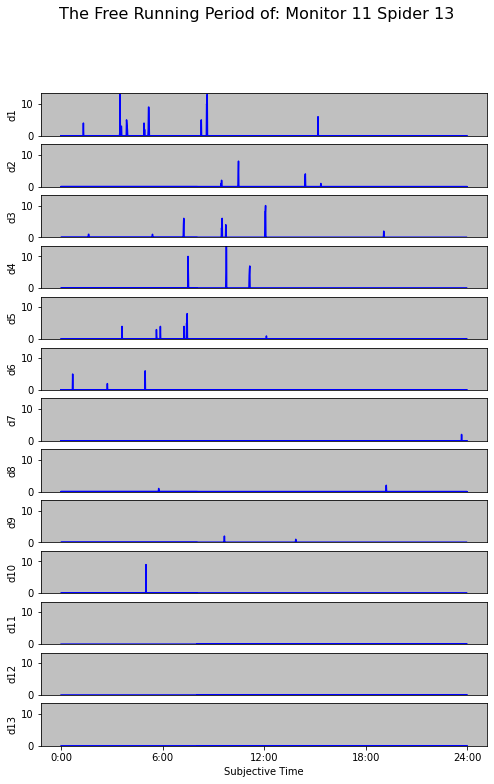

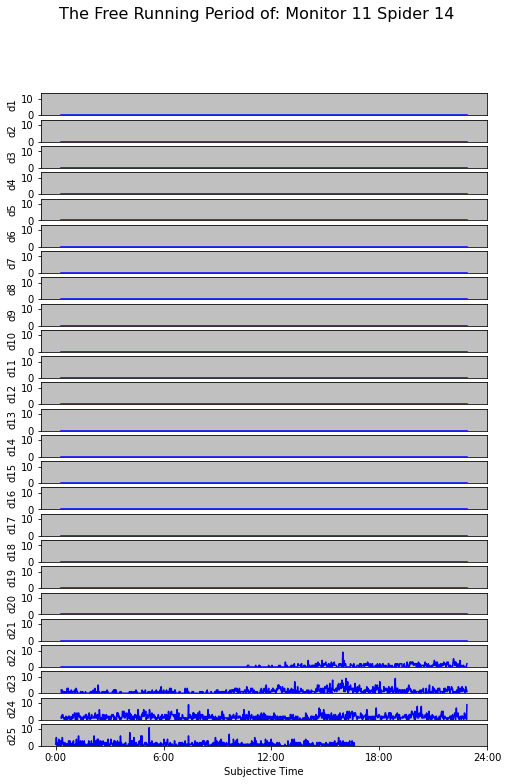

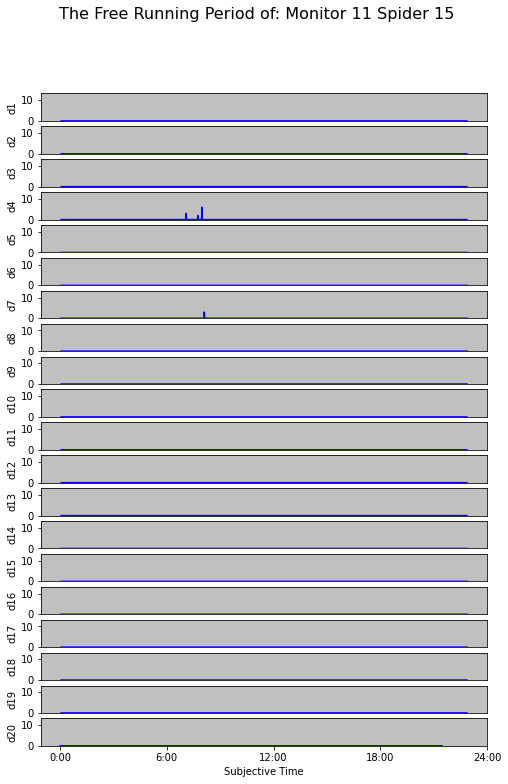

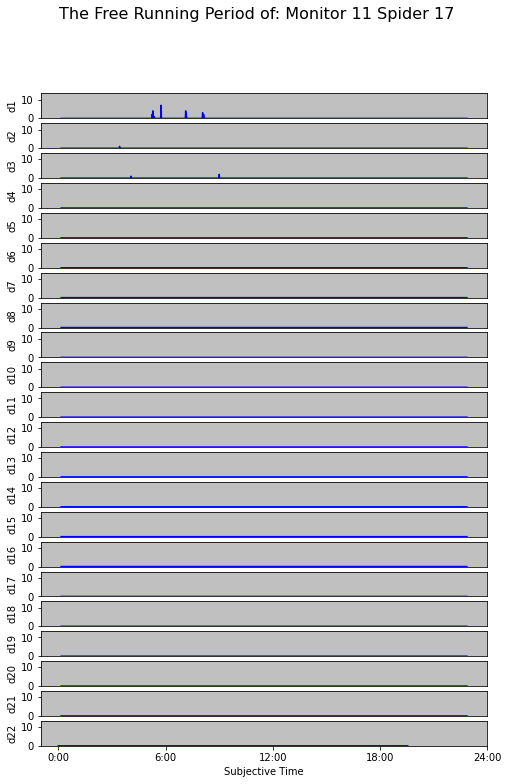

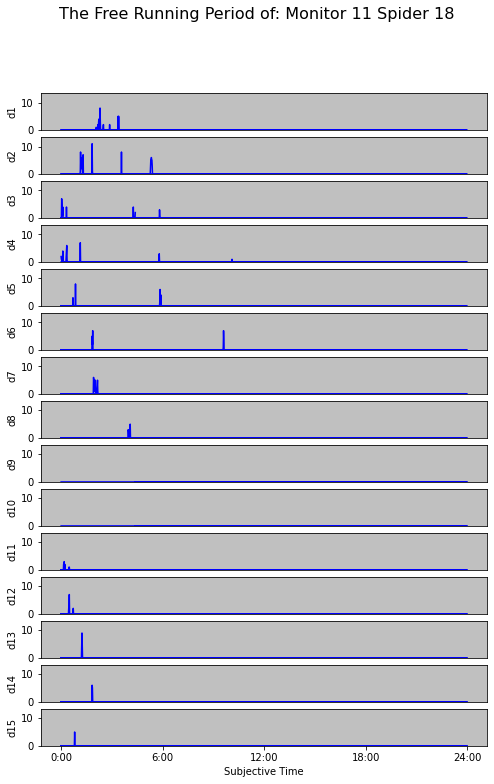

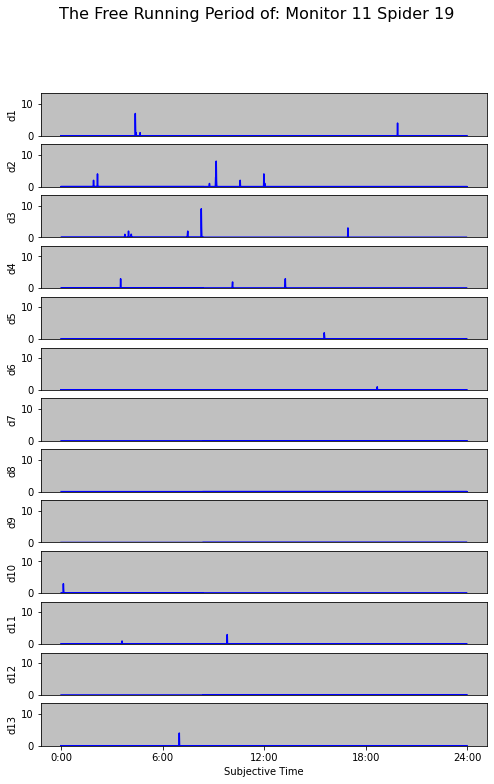

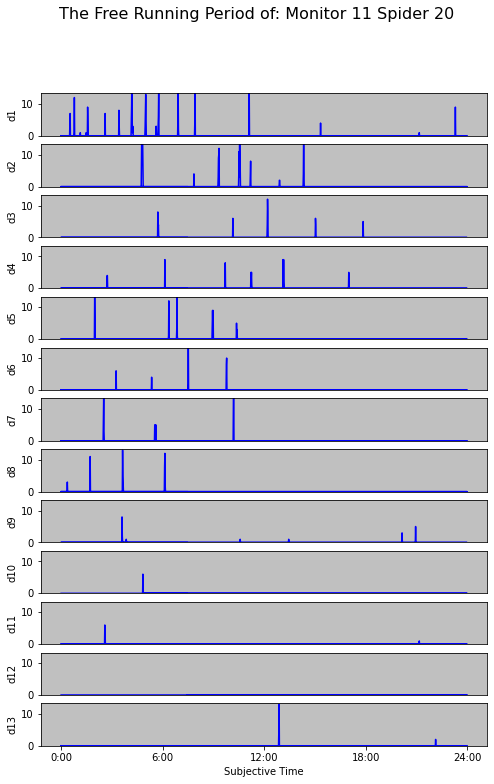

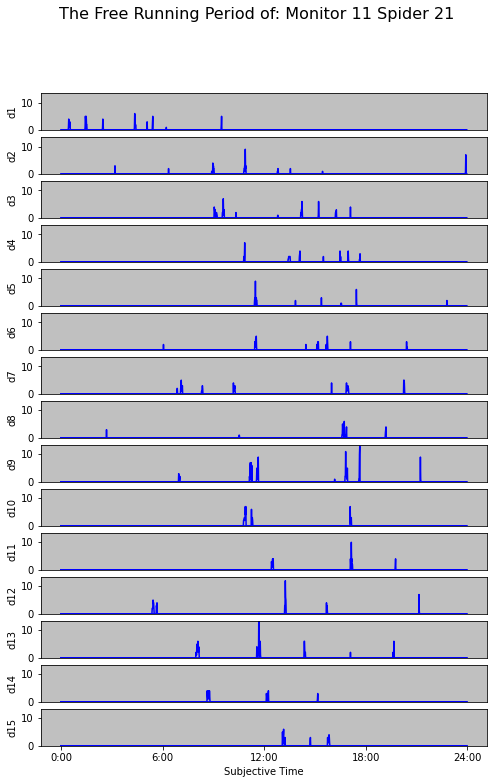

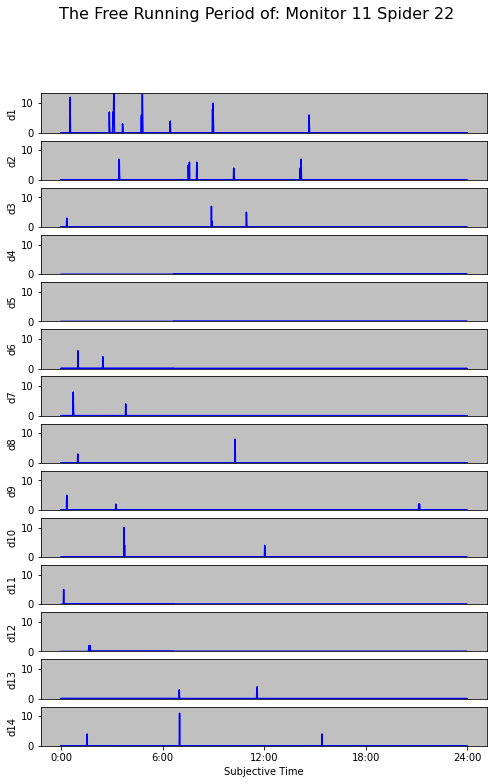

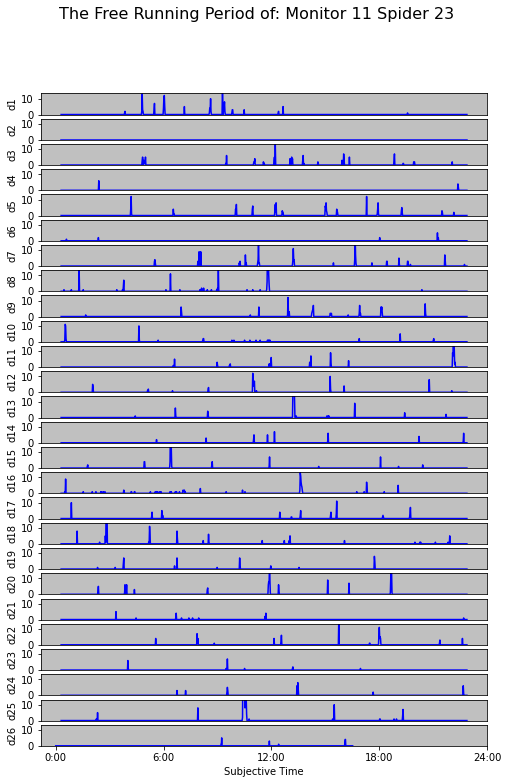

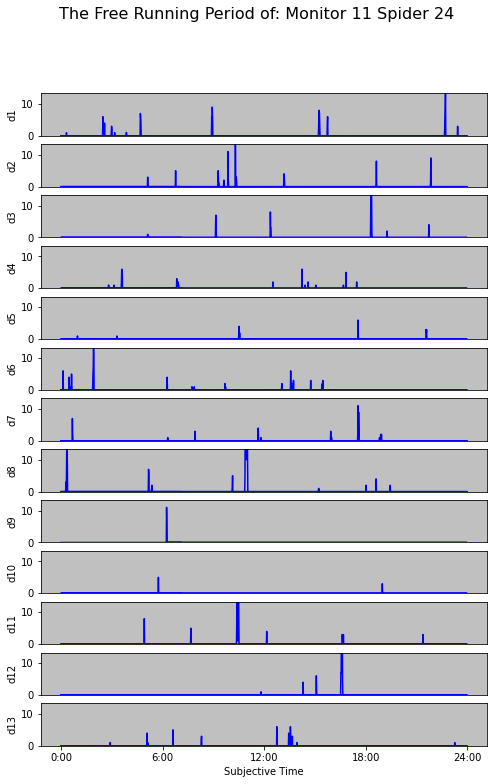

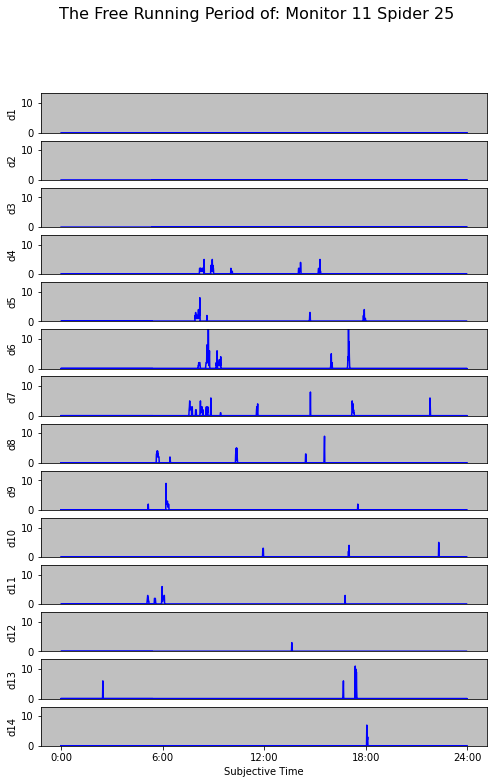

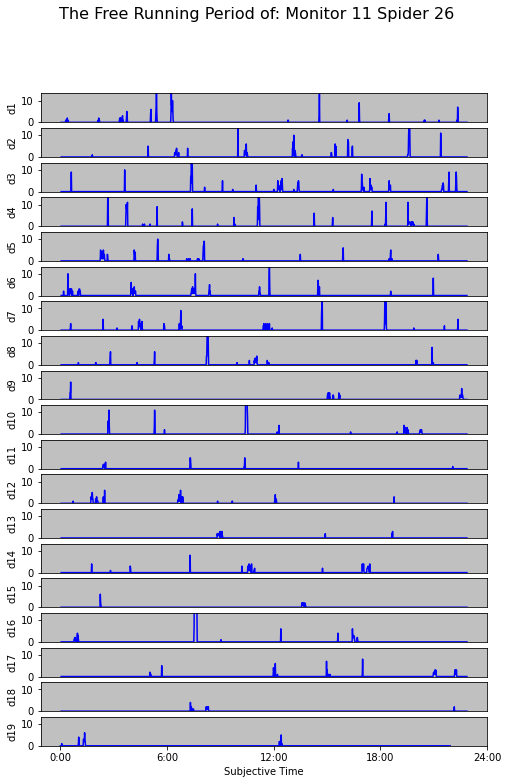

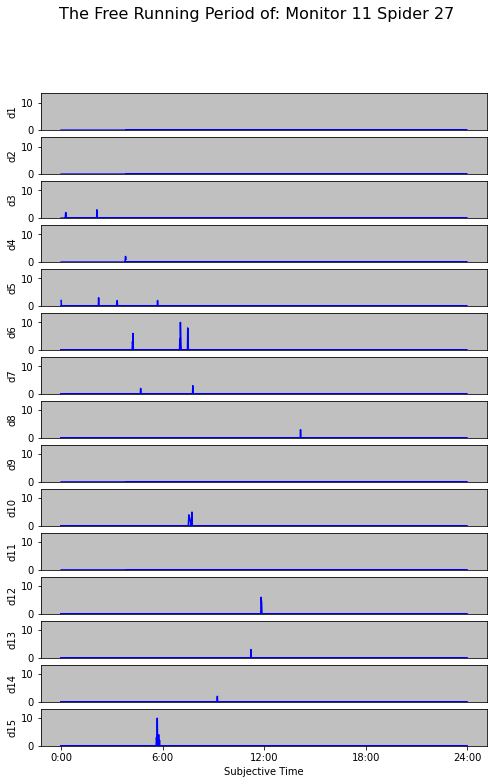

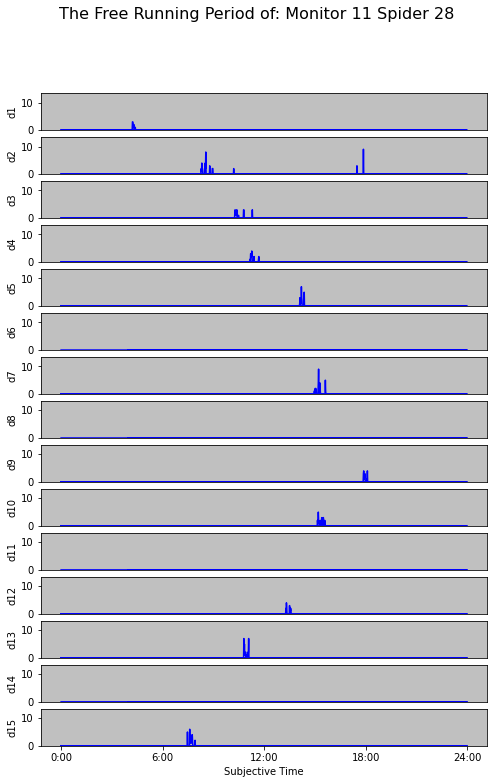

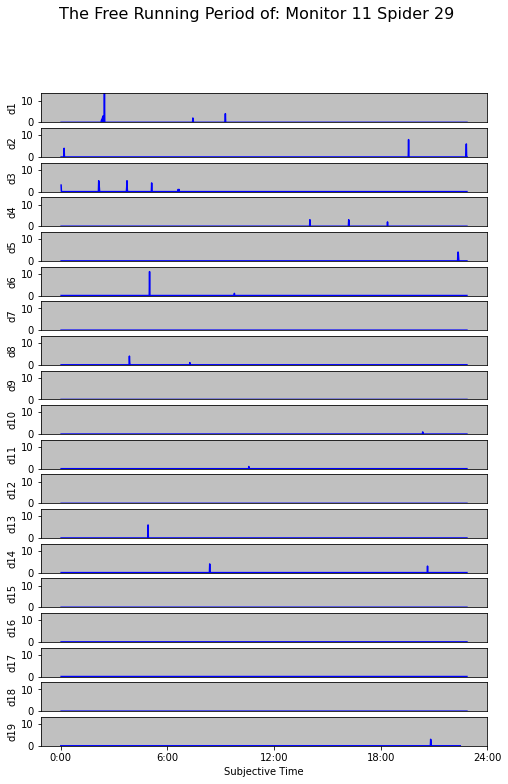

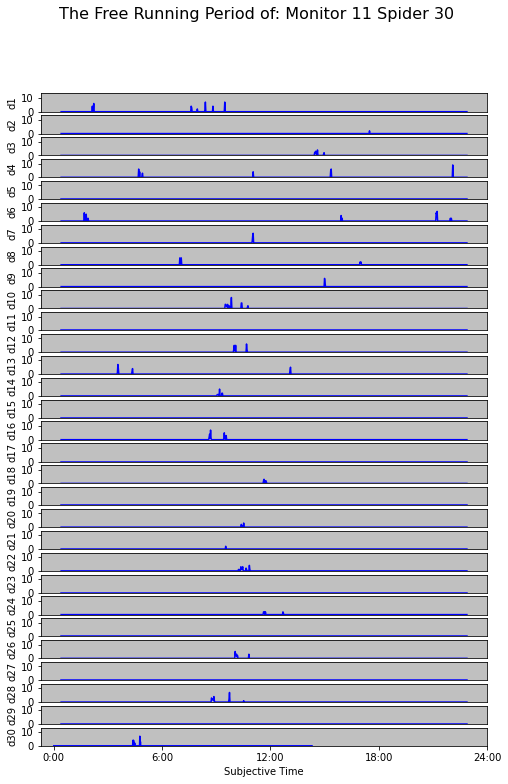

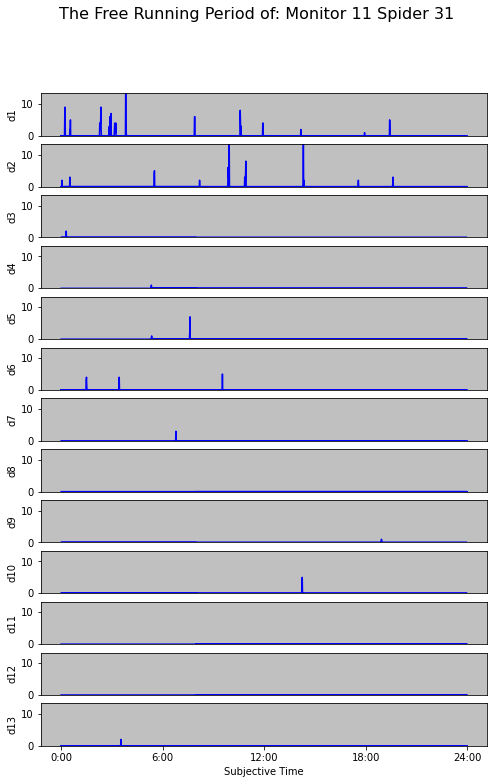

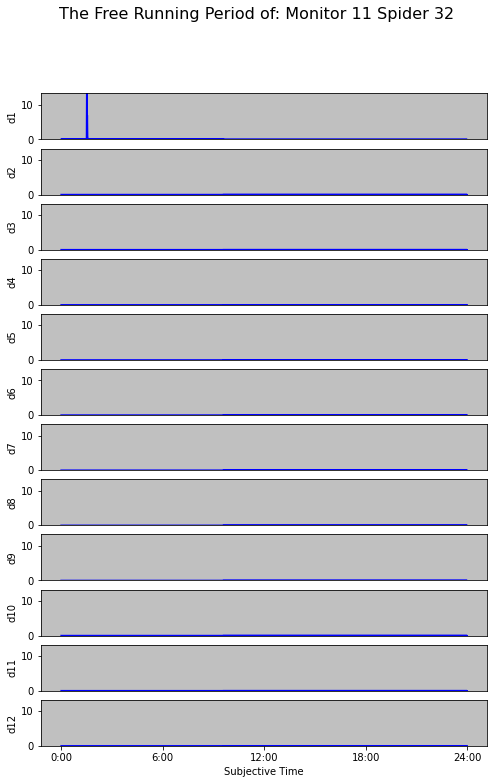

In [14]:
spider_datafile_base = "Frontinella Pyramitela Monitor 11_DD"                        
df_outfront = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
df_outfront = df_outfront.set_index('Spider') 
#outfile = spider_datafile_base + '_Stats.csv'
#df_out.to_csv(outfile)            
display(df_outfront)  

perfront=df_outfront.loc[:,['Period']]
spider_raster_per(dfr2, perfront)

Monitor 12 Spider 1


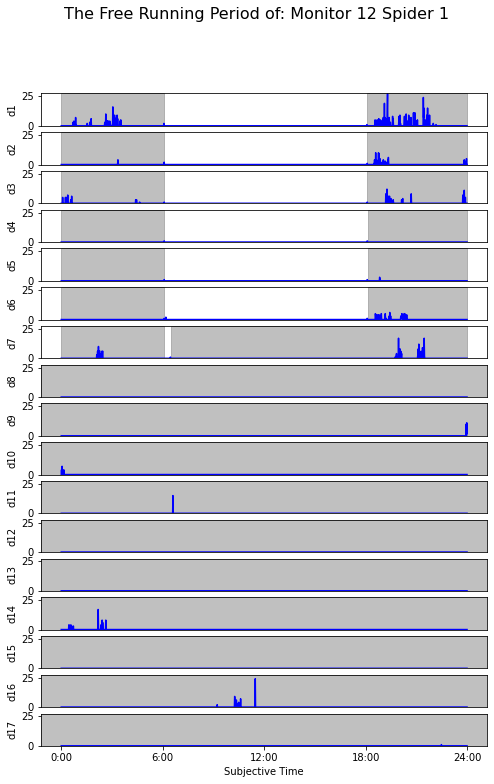

Next spider
Monitor 12 Spider 2


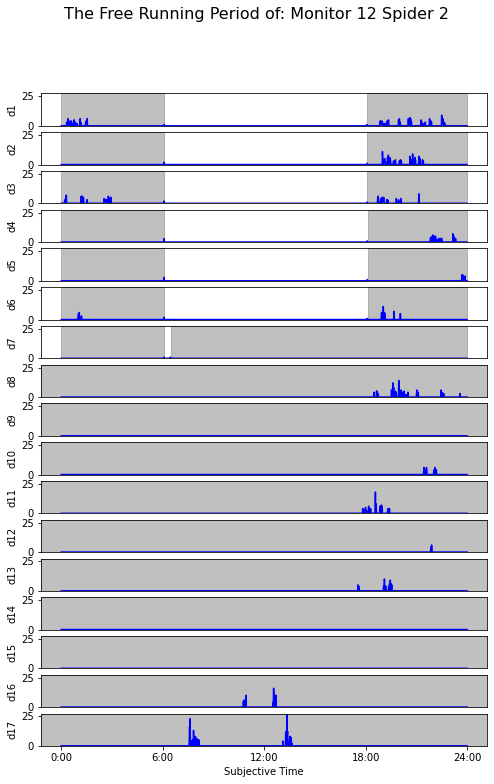

Next spider
Monitor 12 Spider 3


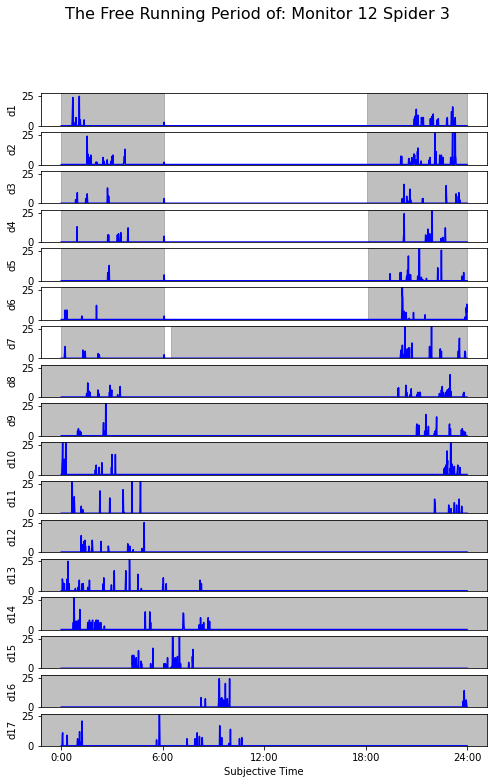

Next spider
Monitor 12 Spider 4


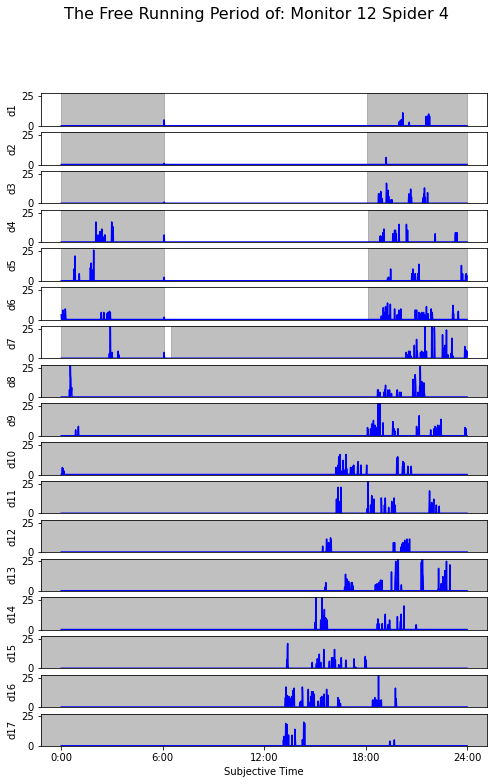

Next spider
Monitor 12 Spider 5


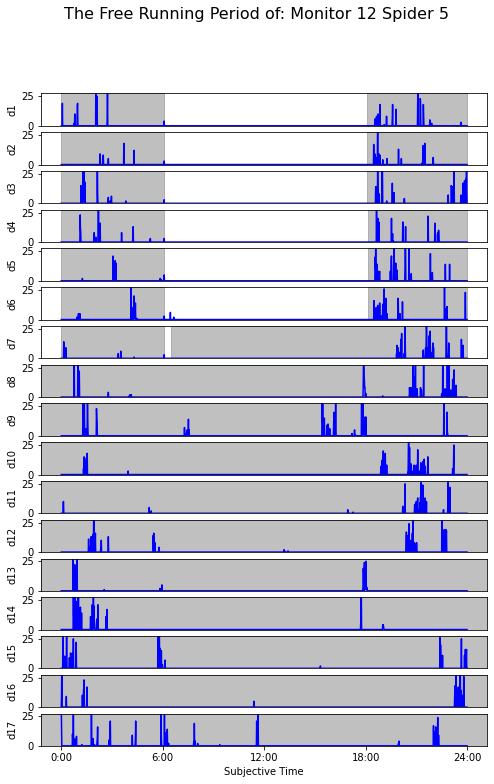

Next spider
Monitor 12 Spider 6


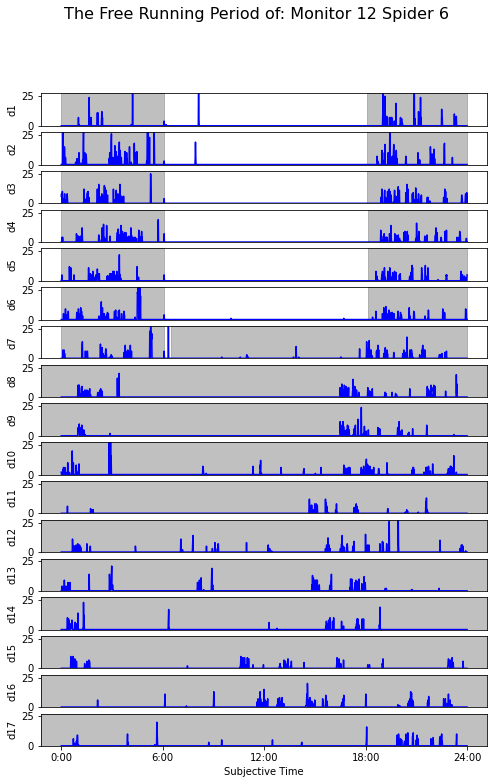

Next spider
Monitor 12 Spider 7


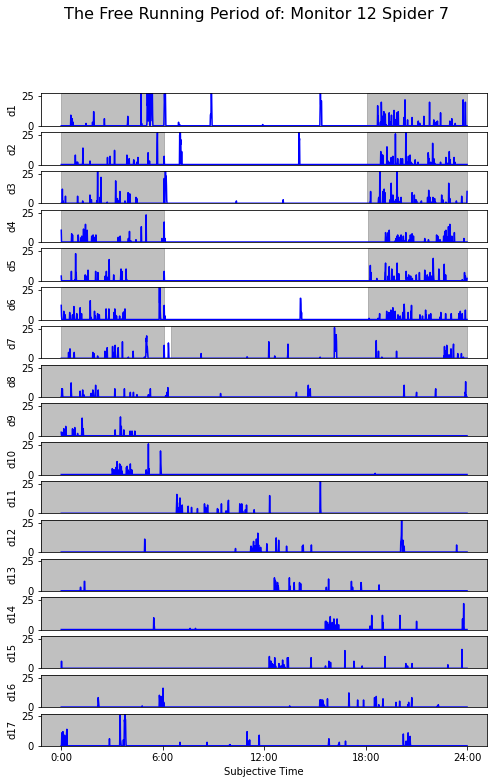

Next spider
Monitor 12 Spider 8


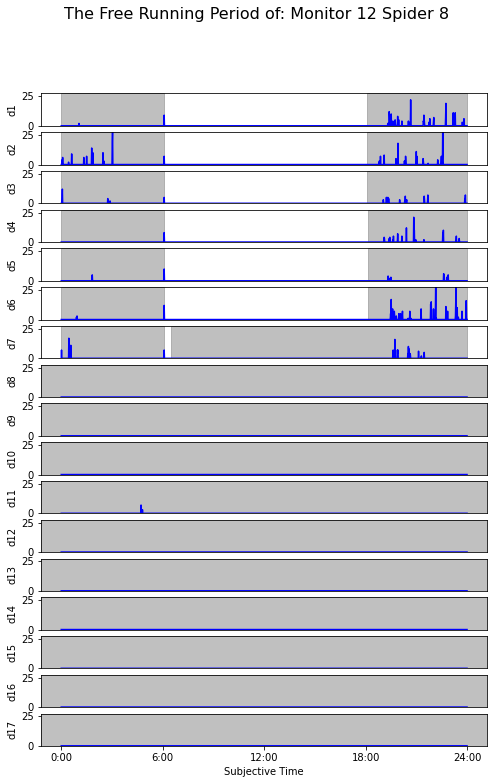

Next spider
Monitor 12 Spider 9


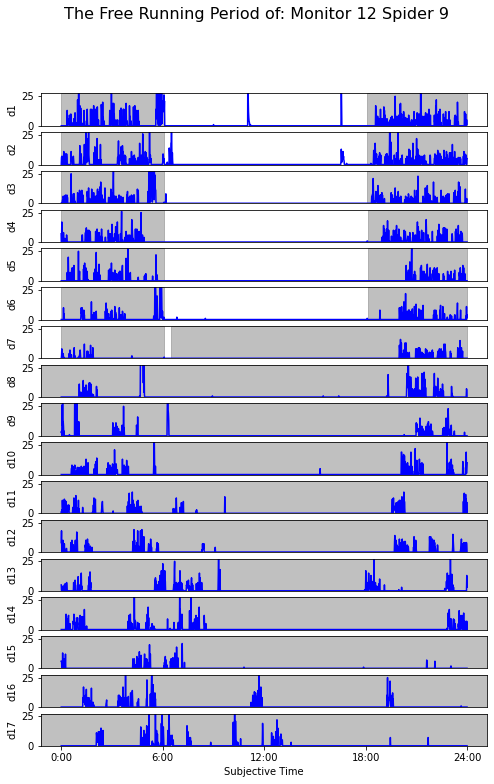

Next spider
Monitor 12 Spider 10


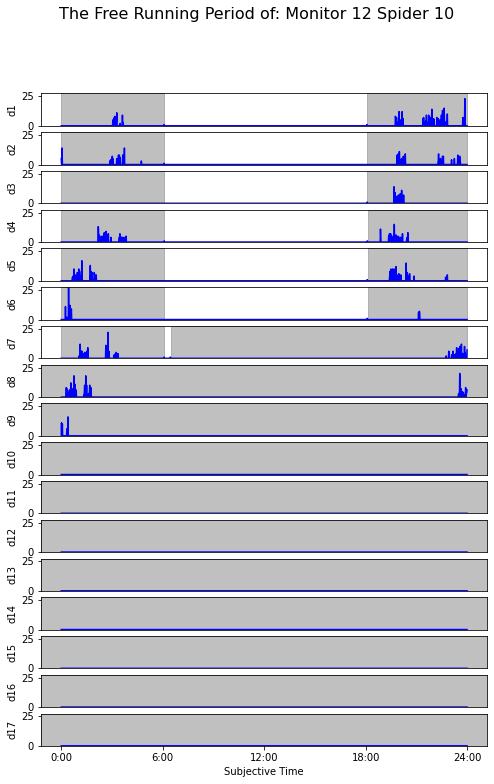

Next spider
Monitor 12 Spider 11


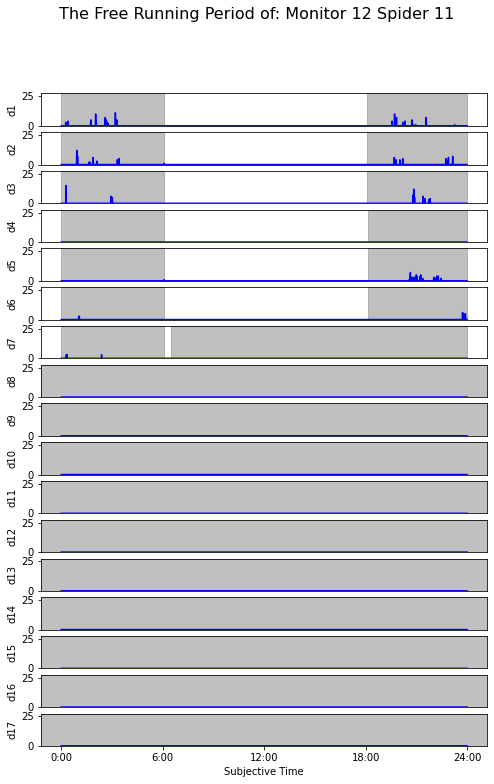

Next spider
Monitor 12 Spider 12


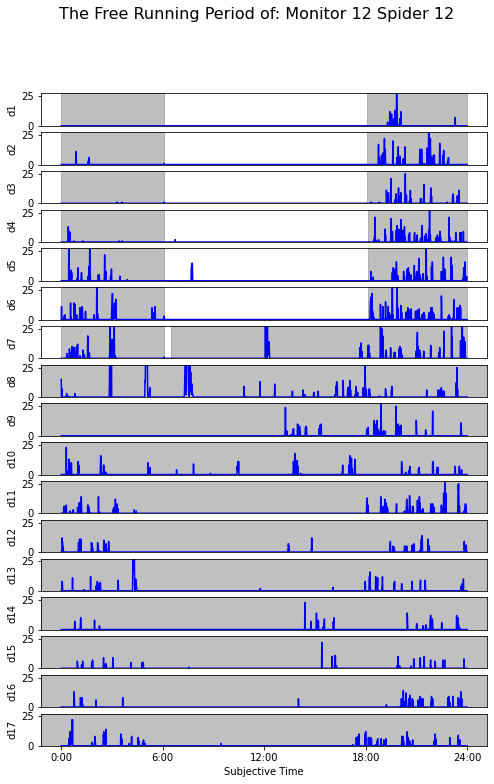

Next spider
Monitor 12 Spider 13


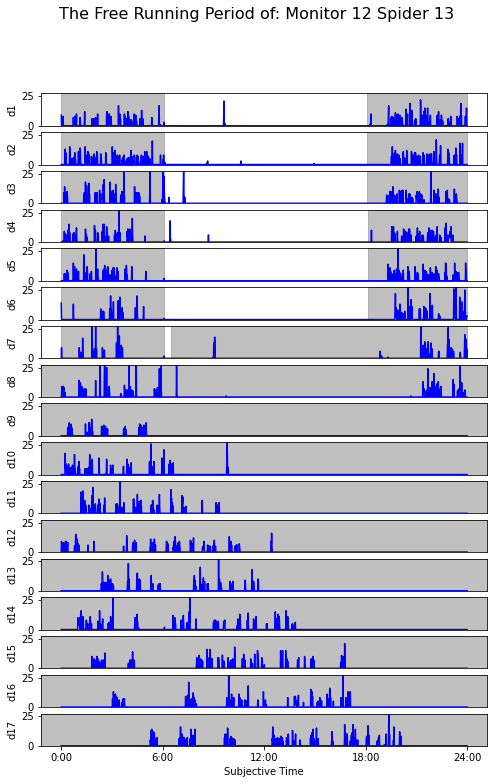

Next spider
Monitor 12 Spider 14


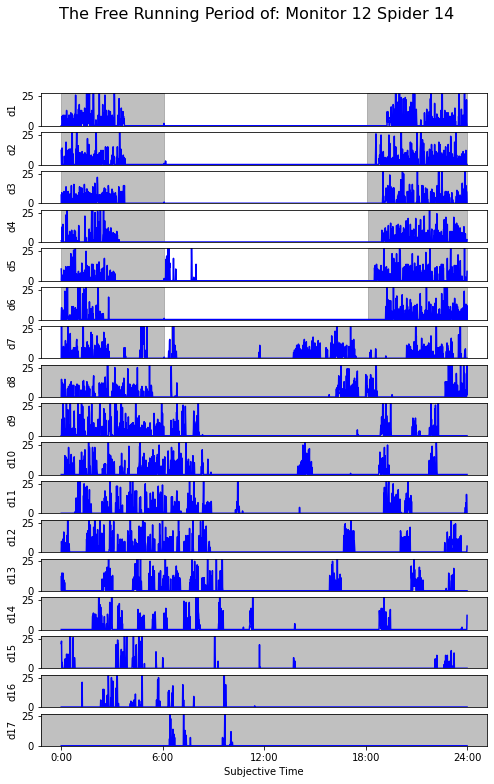

Next spider
Monitor 12 Spider 15


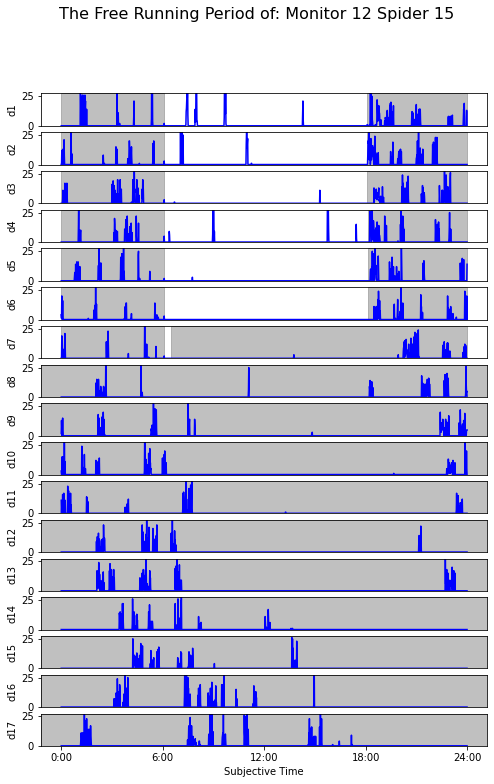

Next spider
Monitor 12 Spider 16


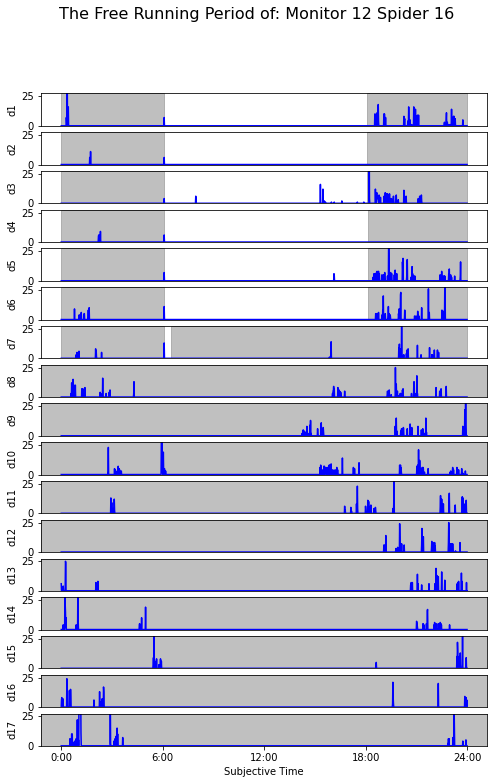

Next spider
Monitor 12 Spider 17


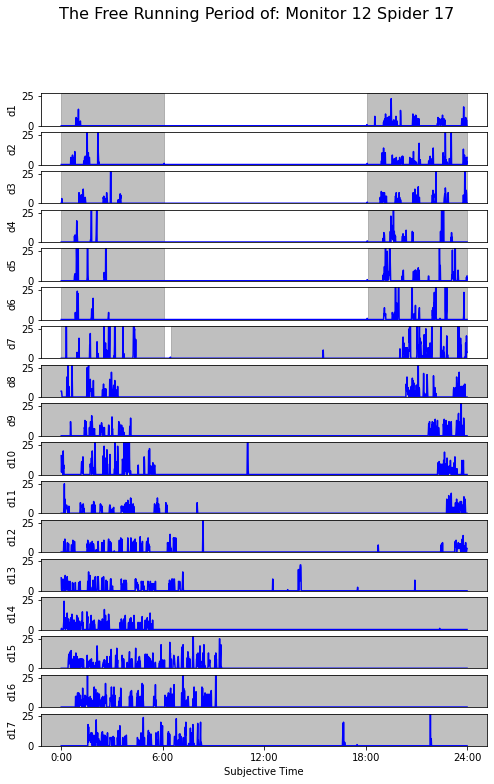

Next spider
Monitor 12 Spider 18


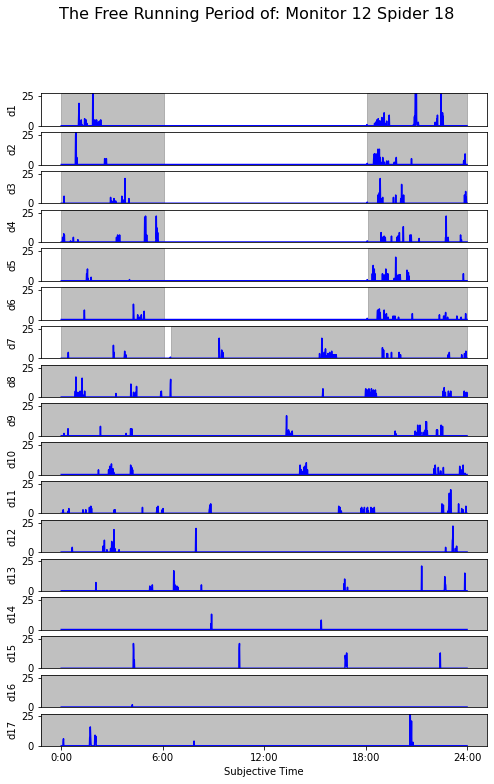

Next spider
Monitor 12 Spider 19


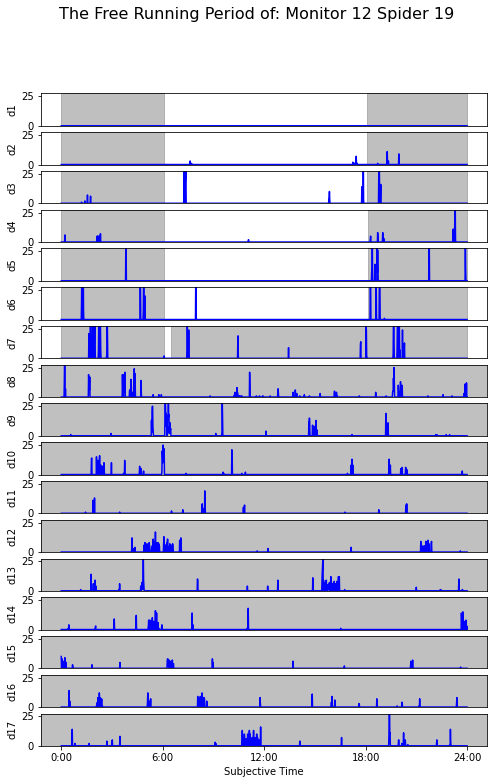

Next spider
Monitor 12 Spider 20


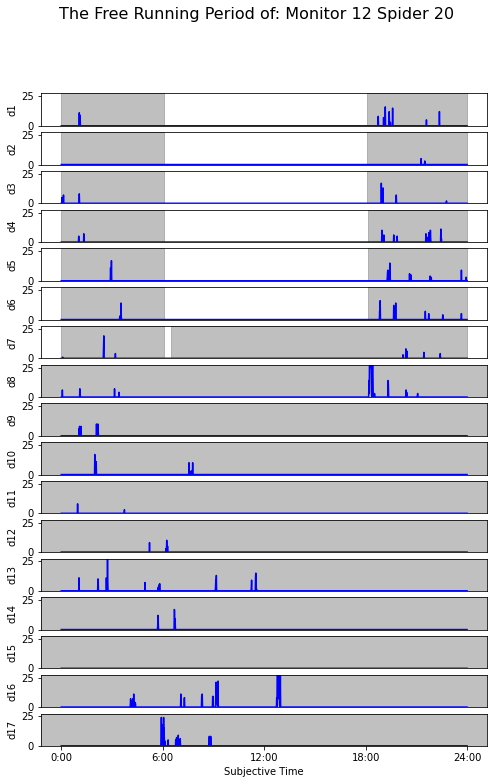

Next spider
Monitor 12 Spider 21


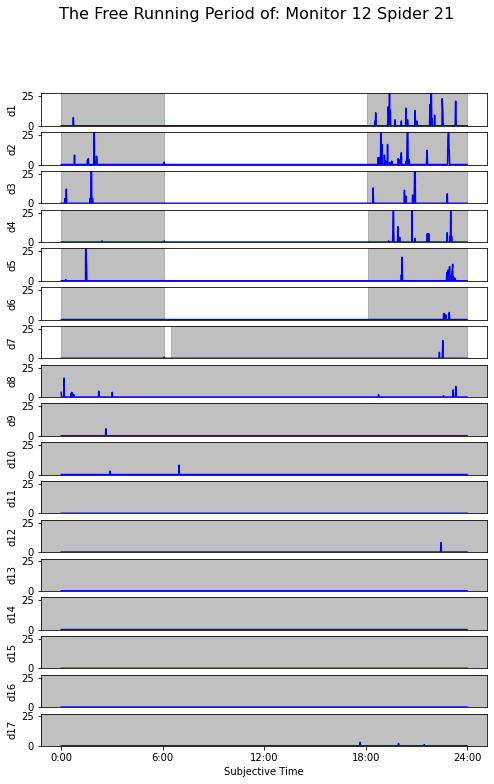

Next spider


In [17]:
dfmicro1=pd.read_csv('Micropholcus Fauroti Monitor 12_LD.csv', index_col=0)
dfmicro2=pd.read_csv('Micropholcus Fauroti Monitor 12_DD.csv', index_col=0)
dfmicro = pd.concat([dfmicro1,dfmicro2])
spider_raster(dfmicro)

Monitor 15 Spider 4


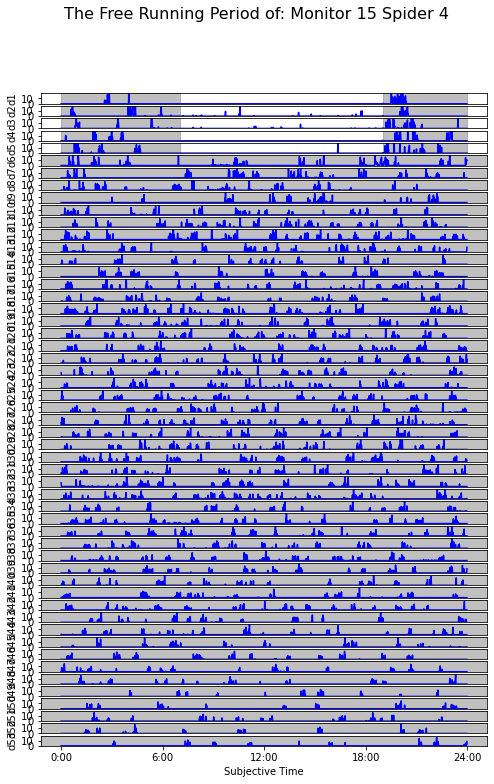

Next spider
Monitor 15 Spider 5


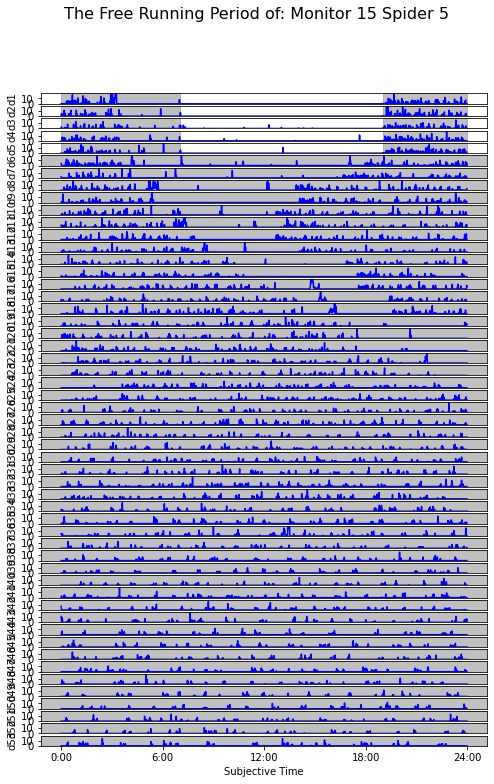

Next spider
Monitor 15 Spider 7


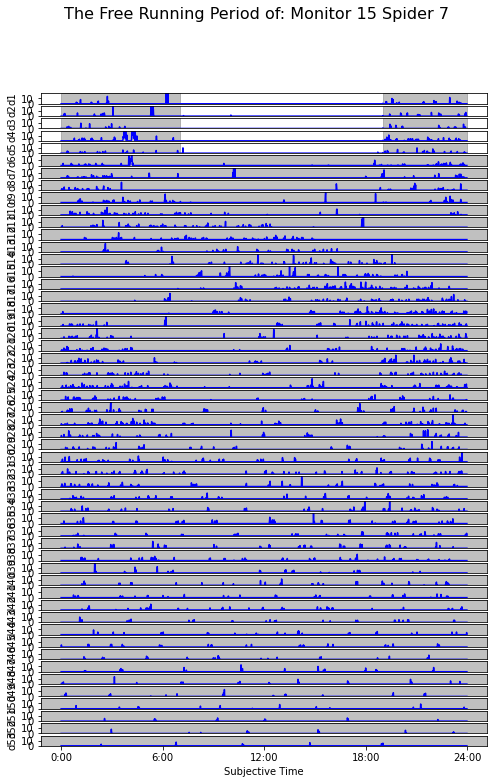

Next spider
Monitor 15 Spider 8


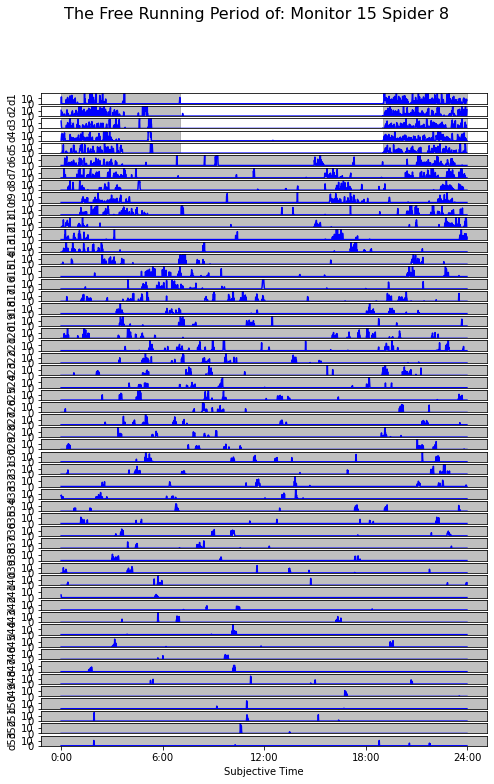

Next spider
Monitor 15 Spider 9


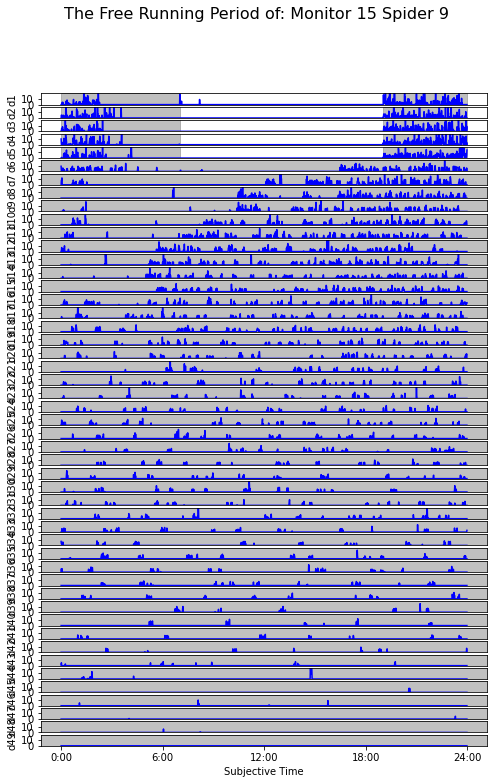

Next spider
Monitor 15 Spider 12


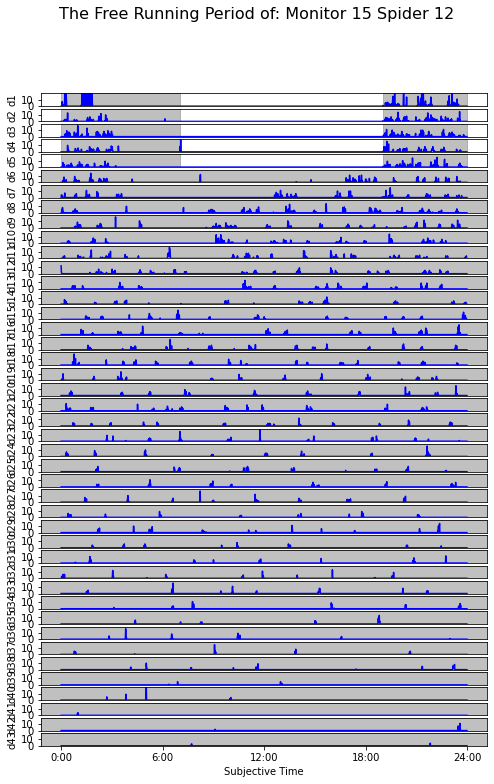

Next spider
Monitor 15 Spider 13


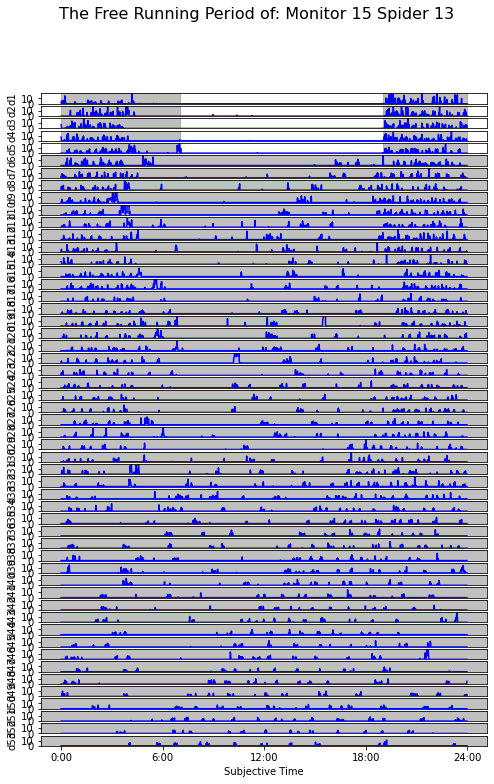

Next spider
Monitor 15 Spider 14


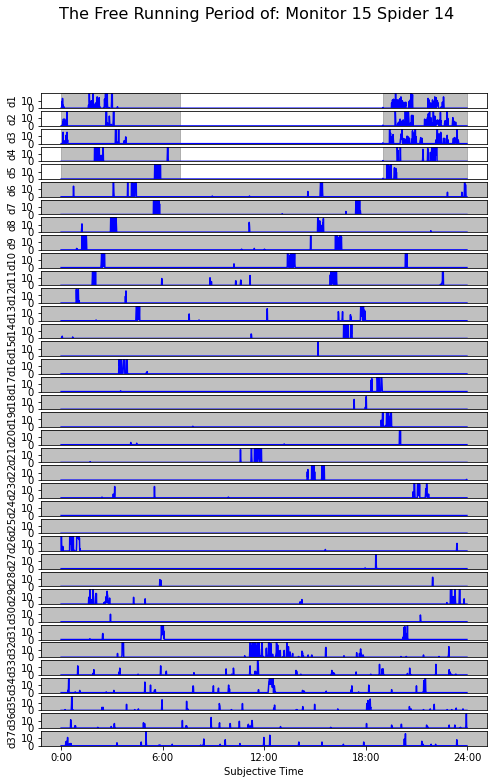

Next spider
Monitor 15 Spider 17


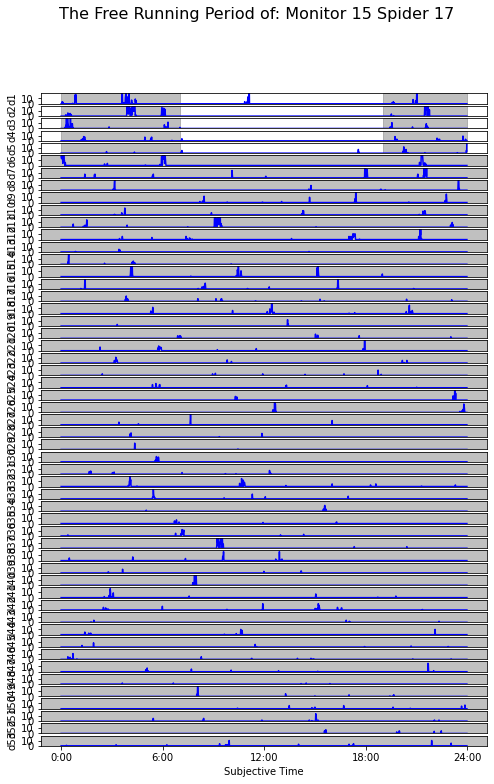

Next spider
Monitor 15 Spider 19


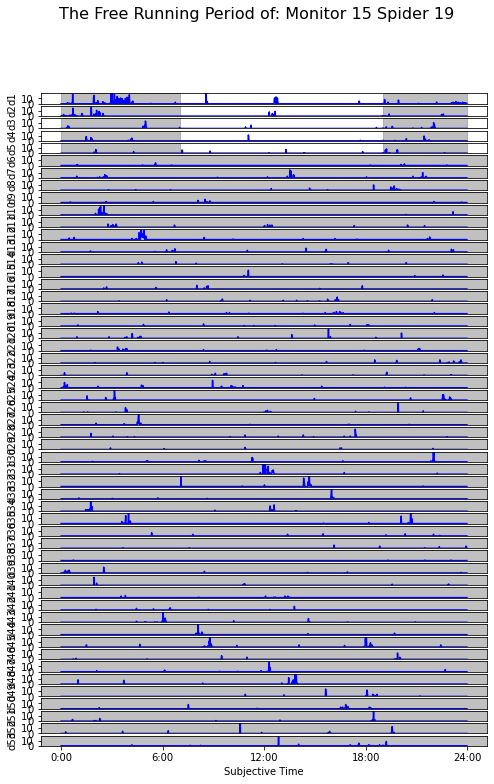

Next spider


In [22]:
dfpho1=pd.read_csv('Pholcus Phalangioides Monitor 15_LD.csv', index_col=0)
dfpho2=pd.read_csv('Pholcus Phalangioides Monitor 15_DD.csv', index_col=0)
dfpho = pd.concat([dfpho1,dfpho2])
spider_raster(dfpho)

['Monitor 15 Spider 4', 'Monitor 15 Spider 5', 'Monitor 15 Spider 7', 'Monitor 15 Spider 8', 'Monitor 15 Spider 9', 'Monitor 15 Spider 12', 'Monitor 15 Spider 13', 'Monitor 15 Spider 14', 'Monitor 15 Spider 17', 'Monitor 15 Spider 19']
10


Period   Amplitude        p value
Spider                                                   
Monitor 15 Spider 4  16.950438   41.364986   1.233946e-12
Monitor 15 Spider 5  24.603535   88.573951   5.675962e-33
Monitor 15 Spider 7  25.406617   85.662861   1.025778e-31
Monitor 15 Spider 8  24.251330  457.556754  7.301526e-193
Monitor 15 Spider 9  23.837992  248.475355  3.132872e-102

Monitor 15 Spider 4
Next spider
Monitor 15 Spider 5
Next spider
Monitor 15 Spider 7
Next spider
Monitor 15 Spider 8
Next spider
Monitor 15 Spider 9
Next spider
Monitor 15 Spider 12
Next spider
Monitor 15 Spider 13
Next spider
Monitor 15 Spider 14
Next spider
Monitor 15 Spider 17
Next spider
Monitor 15 Spider 19
Next spider


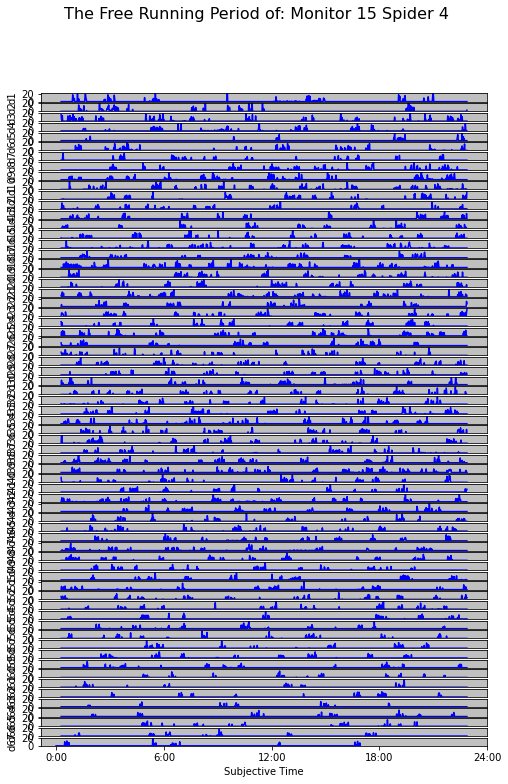

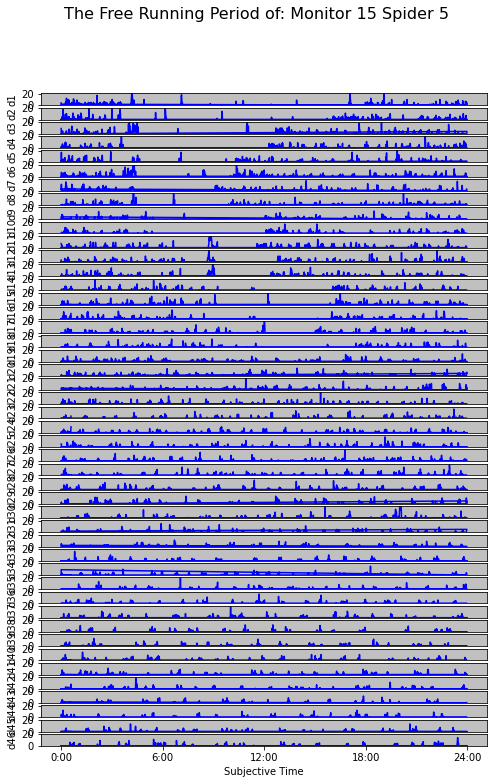

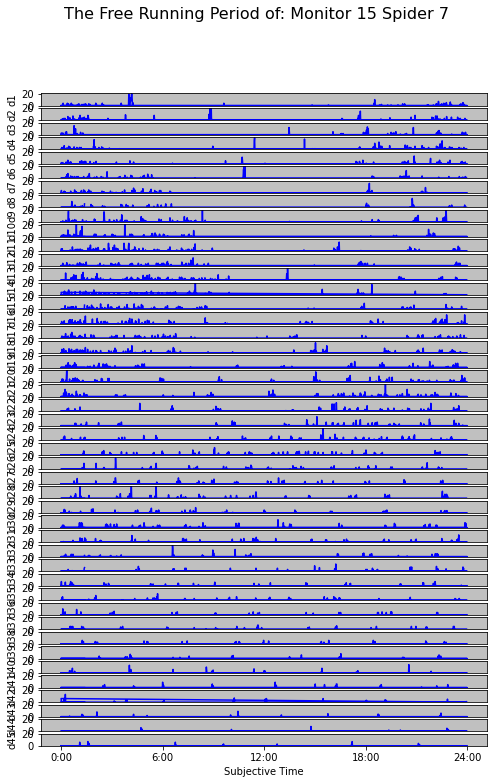

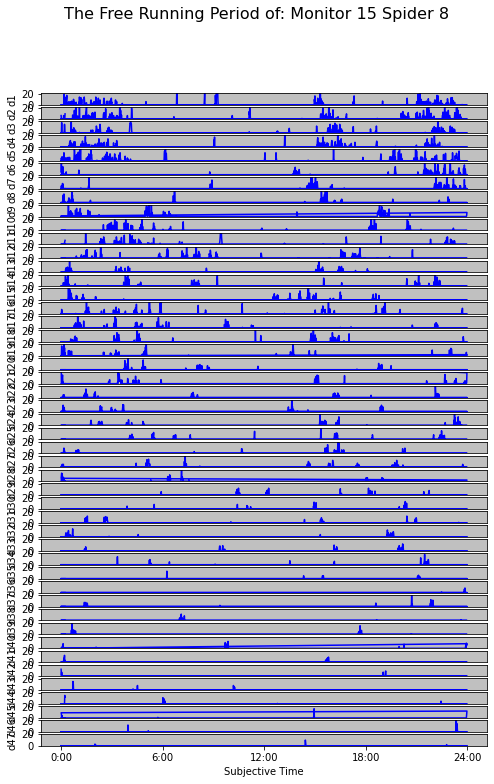

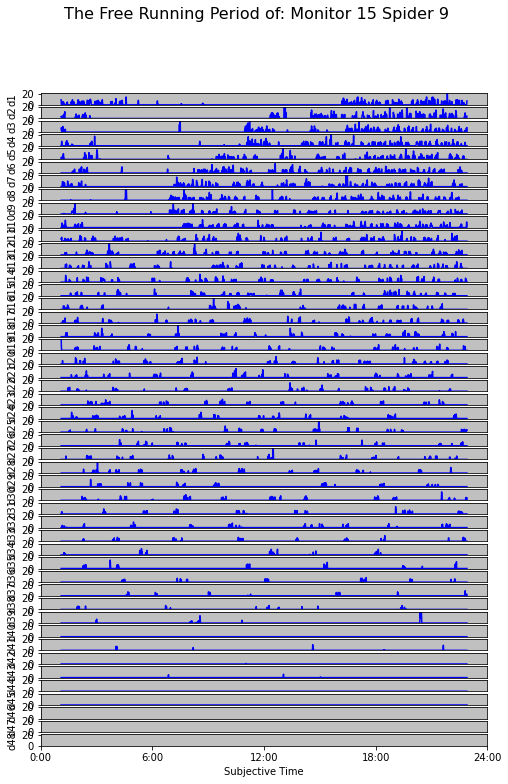

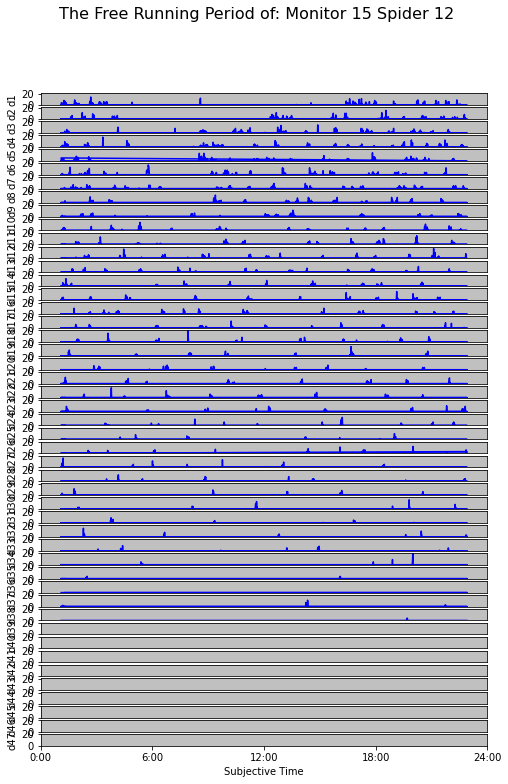

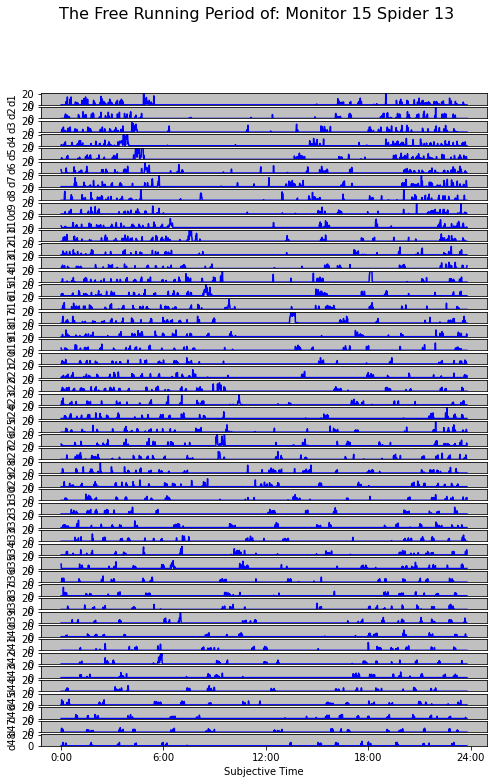

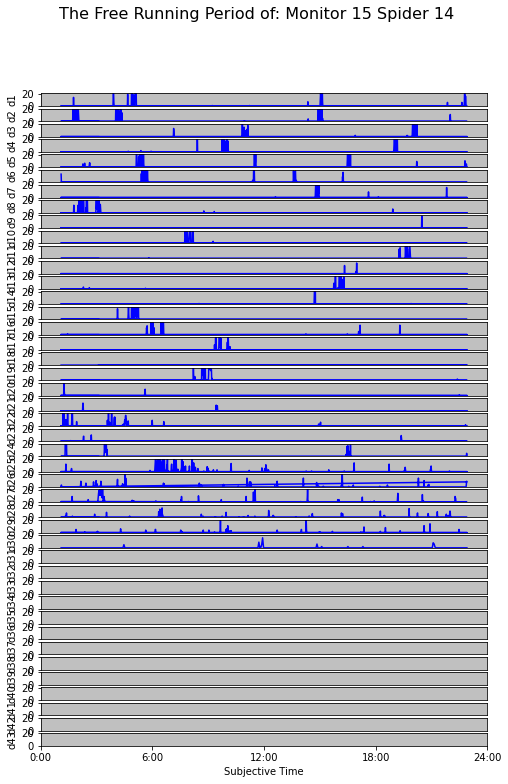

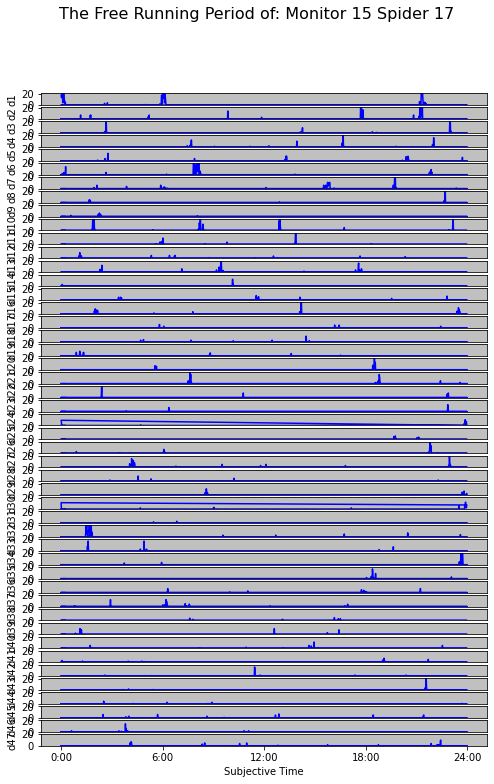

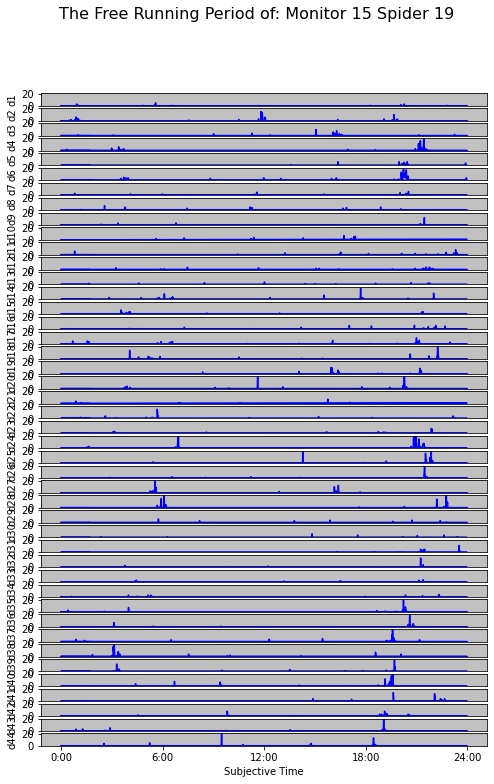

In [24]:
spider_datafile_base = "Pholcus Phalangioides Monitor 15_DD"                        
df_out = LS_Period_Amplitude_FalseAlarm_Pgram(spider_datafile_base)
df_out = df_out.set_index('Spider') 
outfile = spider_datafile_base + '_Stats.csv'
#df_out.to_csv(outfile)            
display(df_out.head())  

perpho=df_out.loc[:,['Period']]
spider_raster_per(dfpho2, perpho)